In [7]:
import json
import os
from io import BytesIO
from os.path import join

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cycler import cycler
from IPython.display import display
from PIL import Image, ImageColor, ImageDraw, ImageFont
from qsprpred.data import QSPRDataset
from qsprpred.data.descriptors.fingerprints import MorganFP
from qsprpred.models import QSPRModel
from rdkit import Chem
from rdkit.Chem import Draw, rdMolDescriptors
from sklearn.metrics import pairwise_distances, r2_score, root_mean_squared_error

a2arcolors = ["#FFCEAD", "#AAC5AC", "#447464", "#575463", "#9E949D", "#C46D5E", "#F4AC32"]

mpl.rcParams['axes.prop_cycle'] = cycler(color=a2arcolors)
sns.set_palette(a2arcolors)

display(sns.color_palette(a2arcolors))

mpl.rcParams.update({'font.size': 17})
COLOR = '#5A5766'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams['axes.edgecolor'] = COLOR

[(1.0, 0.807843137254902, 0.6784313725490196),
 (0.6666666666666666, 0.7725490196078432, 0.6745098039215687),
 (0.26666666666666666, 0.4549019607843137, 0.39215686274509803),
 (0.3411764705882353, 0.32941176470588235, 0.38823529411764707),
 (0.6196078431372549, 0.5803921568627451, 0.615686274509804),
 (0.7686274509803922, 0.42745098039215684, 0.3686274509803922),
 (0.9568627450980393, 0.6745098039215687, 0.19607843137254902)]

In [8]:
# set paths
config_file = "../config.json"
with open(config_file, "r") as f:
    config = json.load(f)

QSPR_PATH = join(config["BASE_DIR"], config["PROCESSED_DATA_DIR"], "QSPR")
QSPR_DATA_PATH = join(QSPR_PATH, 'data')
QSPR_MODELS_PATH = join(QSPR_PATH, 'models')
QSPR_FIGURES_PATH = join(config["BASE_DIR"], config["FIGURES_DIR"], "QSPR")
os.makedirs(QSPR_FIGURES_PATH, exist_ok=True)

In [3]:
# Read in model results files
model_files = os.listdir(QSPR_MODELS_PATH)
model_result_files = [f for f in model_files if f.startswith('hyperparamopt_results')]

model_results = pd.concat([pd.read_csv(join(QSPR_MODELS_PATH, f), sep="\t") for f in model_result_files])

# convert fold_scores column string values to list of floats
model_results["fold_scores"] = model_results["fold_scores"].apply(lambda x: [float(i) for i in x.split(";")])

# use json loads to convert string to dictionary dataset_settings and hyperparameters columns
model_results["dataset_settings"] = model_results["dataset_settings"].apply(lambda x: json.loads(x.replace("'", "\"").replace("None", "null")))
model_results["hyperparameters"] = model_results["hyperparameters"].apply(lambda x: json.loads(x.replace("'", "\"")))

# split dataset_settings dictionary column into separate columns
model_results = pd.concat([model_results.drop(['dataset_settings'], axis=1), model_results['dataset_settings'].apply(pd.Series)], axis=1)

# Add column target_name by taking filename of model_path and splitting name on '_' and taking the second part
model_results["target"] = model_results['model_path'].apply(lambda x: os.path.basename(x).split('_')[1])

model_results_A2AR = model_results[model_results['target'] == 'A2AR']
display(model_results_A2AR.sort_values(by='aggregated_score', ascending=False).head())

model_results_FU = model_results[model_results['target'] == 'FU']
display(model_results_FU.sort_values(by='aggregated_score', ascending=False).head())

model_results_VDSS = model_results[model_results['target'] == 'VDSS']
display(model_results_VDSS.sort_values(by='aggregated_score', ascending=False).head())

model_results_CL = model_results[model_results['target'] == 'CL']
display(model_results_CL.sort_values(by='aggregated_score', ascending=False).head())

aggregated_score                                        fold_scores  \
727           0.687569  [0.6808018135480116, 0.6975162416852492, 0.668...   
2117          0.687364  [0.6731844941167411, 0.688658248996727, 0.6729...   
1881          0.682318  [0.6723265069825561, 0.6927360910536209, 0.660...   
2115          0.677790  [0.661467999754626, 0.6883044282128745, 0.6613...   
725           0.675350  [0.6710142556918288, 0.6948774887917719, 0.652...   

       assessment                                 hyperparameters  \
727   grid_search  {'C': 10, 'cache_size': 1000, 'kernel': 'rbf'}   
2117  grid_search  {'C': 10, 'cache_size': 1000, 'kernel': 'rbf'}   
1881  grid_search  {'C': 10, 'cache_size': 1000, 'kernel': 'rbf'}   
2115  grid_search   {'C': 1, 'cache_size': 1000, 'kernel': 'rbf'}   
725   grid_search   {'C': 1, 'cache_size': 1000, 'kernel': 'rbf'}   

                                             model_path  \
727   /zfsdata/data/helle/01_MainProjects/01_A2AR_in...   
2117  /zfsdata/data/helle/01_MainProjects/01_A2AR_in...   
1881  /zfsdata/data/helle/01_MainProjects/01_A2AR_in...   
2115  /zfsdata/data/helle/01_MainProjects/01_A2AR_in...   
725   /zfsdata/data/helle/01_MainProjects/01_A2AR_in...   

                                           dataset_path algorithm  low_var_th  \
727   /zfsdata/data/helle/01_MainProjects/01_A2AR_in...       SVR         NaN   
2117  /zfsdata/data/helle/01_MainProjects/01_A2AR_in...       SVR         NaN   
1881  /zfsdata/data/helle/01_MainProjects/01_A2AR_in...       SVR         NaN   
2115  /zfsdata/data/helle/01_MainProjects/01_A2AR_in...       SVR         NaN   
725   /zfsdata/data/helle/01_MainProjects/01_A2AR_in...       SVR         NaN   

      high_corr_th  boruta_perc feature_calculators target  
727           0.99         80.0   [MorganFP, RDkit]   A2AR  
2117          0.95         80.0   [MorganFP, RDkit]   A2AR  
1881          0.90         80.0   [MorganFP, RDkit]   A2AR  
2115          0.95         80.0   [MorganFP, RDkit]   A2AR  
725           0.99         80.0   [MorganFP, RDkit]   A2AR

aggregated_score                                        fold_scores  \
1379          0.646029  [0.7264417154283414, 0.6184576174242895, 0.619...   
1381          0.640628  [0.7166089040072504, 0.6116621977687595, 0.614...   
3071          0.637560  [0.7126539767382578, 0.6085360987073078, 0.605...   
2093          0.634050  [0.7066305941897206, 0.6049269729279667, 0.597...   
2095          0.633150  [0.7054322292802384, 0.6035581858360997, 0.598...   

       assessment                                 hyperparameters  \
1379  grid_search   {'C': 1, 'cache_size': 1000, 'kernel': 'rbf'}   
1381  grid_search  {'C': 10, 'cache_size': 1000, 'kernel': 'rbf'}   
3071  grid_search   {'C': 1, 'cache_size': 1000, 'kernel': 'rbf'}   
2093  grid_search   {'C': 1, 'cache_size': 1000, 'kernel': 'rbf'}   
2095  grid_search  {'C': 10, 'cache_size': 1000, 'kernel': 'rbf'}   

                                             model_path  \
1379  /zfsdata/data/helle/01_MainProjects/01_A2AR_in...   
1381  /zfsdata/data/helle/01_MainProjects/01_A2AR_in...   
3071  /zfsdata/data/helle/01_MainProjects/01_A2AR_in...   
2093  /zfsdata/data/helle/01_MainProjects/01_A2AR_in...   
2095  /zfsdata/data/helle/01_MainProjects/01_A2AR_in...   

                                           dataset_path algorithm  low_var_th  \
1379  /zfsdata/data/helle/01_MainProjects/01_A2AR_in...       SVR         NaN   
1381  /zfsdata/data/helle/01_MainProjects/01_A2AR_in...       SVR         NaN   
3071  /zfsdata/data/helle/01_MainProjects/01_A2AR_in...       SVR         NaN   
2093  /zfsdata/data/helle/01_MainProjects/01_A2AR_in...       SVR         NaN   
2095  /zfsdata/data/helle/01_MainProjects/01_A2AR_in...       SVR         NaN   

      high_corr_th  boruta_perc feature_calculators target  
1379          0.99         80.0   [MorganFP, RDkit]     FU  
1381          0.99         80.0   [MorganFP, RDkit]     FU  
3071          0.95         80.0   [MorganFP, RDkit]     FU  
2093          0.90         80.0   [MorganFP, RDkit]     FU  
2095          0.90         80.0   [MorganFP, RDkit]     FU

aggregated_score                                        fold_scores  \
2791          0.512646  [0.5542413406099245, 0.5066861427893539, 0.495...   
1335          0.511642  [0.5687803168163792, 0.5046099776459138, 0.490...   
945           0.511537  [0.550212901276945, 0.49850653126617084, 0.501...   
1337          0.508979  [0.5704320983822131, 0.4932541833339057, 0.485...   
938           0.508143  [0.5094967940094575, 0.5354836165875447, 0.512...   

       assessment                                 hyperparameters  \
2791  grid_search   {'C': 1, 'cache_size': 1000, 'kernel': 'rbf'}   
1335  grid_search   {'C': 1, 'cache_size': 1000, 'kernel': 'rbf'}   
945   grid_search   {'C': 1, 'cache_size': 1000, 'kernel': 'rbf'}   
1337  grid_search  {'C': 10, 'cache_size': 1000, 'kernel': 'rbf'}   
938   grid_search         {'max_depth': 20, 'n_estimators': 1000}   

                                             model_path  \
2791  /zfsdata/data/helle/01_MainProjects/01_A2AR_in...   
1335  /zfsdata/data/helle/01_MainProjects/01_A2AR_in...   
945   /zfsdata/data/helle/01_MainProjects/01_A2AR_in...   
1337  /zfsdata/data/helle/01_MainProjects/01_A2AR_in...   
938   /zfsdata/data/helle/01_MainProjects/01_A2AR_in...   

                                           dataset_path  \
2791  /zfsdata/data/helle/01_MainProjects/01_A2AR_in...   
1335  /zfsdata/data/helle/01_MainProjects/01_A2AR_in...   
945   /zfsdata/data/helle/01_MainProjects/01_A2AR_in...   
1337  /zfsdata/data/helle/01_MainProjects/01_A2AR_in...   
938   /zfsdata/data/helle/01_MainProjects/01_A2AR_in...   

                  algorithm  low_var_th  high_corr_th  boruta_perc  \
2791                    SVR         NaN          0.99         80.0   
1335                    SVR         NaN          0.95         80.0   
945                     SVR         NaN          0.90         80.0   
1337                    SVR         NaN          0.95         80.0   
938   RandomForestRegressor         NaN          0.90         80.0   

     feature_calculators target  
2791   [MorganFP, RDkit]   VDSS  
1335   [MorganFP, RDkit]   VDSS  
945    [MorganFP, RDkit]   VDSS  
1337   [MorganFP, RDkit]   VDSS  
938    [MorganFP, RDkit]   VDSS

aggregated_score                                        fold_scores  \
1659          0.313617  [0.26728182973826264, 0.40590858866570767, 0.3...   
1401          0.312847  [0.27161364814801836, 0.39354737465274303, 0.3...   
313           0.310360  [0.2761297555204588, 0.4003416383600773, 0.295...   
1661          0.304216  [0.2804462663474133, 0.38933943546904537, 0.26...   
1403          0.300121  [0.2831297408843336, 0.3842368470839713, 0.256...   

       assessment                                 hyperparameters  \
1659  grid_search   {'C': 1, 'cache_size': 1000, 'kernel': 'rbf'}   
1401  grid_search   {'C': 1, 'cache_size': 1000, 'kernel': 'rbf'}   
313   grid_search   {'C': 1, 'cache_size': 1000, 'kernel': 'rbf'}   
1661  grid_search  {'C': 10, 'cache_size': 1000, 'kernel': 'rbf'}   
1403  grid_search  {'C': 10, 'cache_size': 1000, 'kernel': 'rbf'}   

                                             model_path  \
1659  /zfsdata/data/helle/01_MainProjects/01_A2AR_in...   
1401  /zfsdata/data/helle/01_MainProjects/01_A2AR_in...   
313   /zfsdata/data/helle/01_MainProjects/01_A2AR_in...   
1661  /zfsdata/data/helle/01_MainProjects/01_A2AR_in...   
1403  /zfsdata/data/helle/01_MainProjects/01_A2AR_in...   

                                           dataset_path algorithm  low_var_th  \
1659  /zfsdata/data/helle/01_MainProjects/01_A2AR_in...       SVR         NaN   
1401  /zfsdata/data/helle/01_MainProjects/01_A2AR_in...       SVR         NaN   
313   /zfsdata/data/helle/01_MainProjects/01_A2AR_in...       SVR         NaN   
1661  /zfsdata/data/helle/01_MainProjects/01_A2AR_in...       SVR         NaN   
1403  /zfsdata/data/helle/01_MainProjects/01_A2AR_in...       SVR         NaN   

      high_corr_th  boruta_perc feature_calculators target  
1659          0.95         80.0   [MorganFP, RDkit]     CL  
1401          0.90         80.0   [MorganFP, RDkit]     CL  
313           0.99         80.0   [MorganFP, RDkit]     CL  
1661          0.95         80.0   [MorganFP, RDkit]     CL  
1403          0.90         80.0   [MorganFP, RDkit]     CL

In [4]:
# Get best model paths
best_model_A2AR = model_results_A2AR.sort_values(by='aggregated_score', ascending=False).head(1)
best_model_A2AR_path = best_model_A2AR.model_path.values[0]
best_data_A2AR_path = best_model_A2AR.dataset_path.values[0]
best_data_A2AR = QSPRDataset.fromFile(best_data_A2AR_path)
print(best_model_A2AR_path)

best_model_FU = model_results_FU.sort_values(by='aggregated_score', ascending=False).head(1)
best_model_FU_path = best_model_FU.model_path.values[0]
best_data_FU_path = best_model_FU.dataset_path.values[0]
best_data_FU = QSPRDataset.fromFile(best_data_FU_path)
print(best_model_FU_path)

best_model_VDSS = model_results_VDSS.sort_values(by='aggregated_score', ascending=False).head(1)
best_model_VDSS_path = best_model_VDSS.model_path.values[0]
best_data_VDSS_path = best_model_VDSS.dataset_path.values[0]
best_data_VDSS = QSPRDataset.fromFile(best_data_VDSS_path)
print(best_model_VDSS_path)

best_model_CL = model_results_CL.sort_values(by='aggregated_score', ascending=False).head(1)
best_model_CL_path = best_model_CL.model_path.values[0]
best_data_CL_path = best_model_CL.dataset_path.values[0]
best_data_CL = QSPRDataset.fromFile(best_data_CL_path)
print(best_model_CL_path)


/zfsdata/data/helle/01_MainProjects/01_A2AR_in_cancer/Data/02_processed/QSPR/models/SVR_A2AR_MorganFP_RDkit_B_80_HC_0.99/SVR_A2AR_MorganFP_RDkit_B_80_HC_0.99_meta.json
/zfsdata/data/helle/01_MainProjects/01_A2AR_in_cancer/Data/02_processed/QSPR/models/SVR_FU_MorganFP_RDkit_B_80_HC_0.99/SVR_FU_MorganFP_RDkit_B_80_HC_0.99_meta.json
/zfsdata/data/helle/01_MainProjects/01_A2AR_in_cancer/Data/02_processed/QSPR/models/SVR_VDSS_MorganFP_RDkit_B_80_HC_0.99/SVR_VDSS_MorganFP_RDkit_B_80_HC_0.99_meta.json
/zfsdata/data/helle/01_MainProjects/01_A2AR_in_cancer/Data/02_processed/QSPR/models/SVR_CL_MorganFP_RDkit_B_80_HC_0.95/SVR_CL_MorganFP_RDkit_B_80_HC_0.95_meta.json


## Analyze Grid search

Analysis of the grid search results:
* Table with grid search results (Supplementary Table S2)

In [9]:
# Table of hyperparameter optimization results (Supplementary Table S2)
hyperparamopt = pd.read_csv(f"{QSPR_MODELS_PATH}/hyperparamopt_results_20240929_190928.tsv", sep="\t")
hyperparamopt["Target"] = hyperparamopt["model_path"].apply(lambda x: os.path.basename(x).split('_')[1])
hyperparamopt["fold_scores"] = hyperparamopt["fold_scores"].apply(lambda x: [float(i) for i in x.split(";")])

# for each value in dataset settings split feature_calculators to separate column
hyperparamopt["features"] = hyperparamopt["dataset_settings"].apply(lambda x: x.split("'feature_calculators': ")[-1].replace("[", "").replace("]}", "").replace("'", ""))
hyperparamopt["filters"] = hyperparamopt["dataset_settings"].apply(lambda x: x.split(", 'feature_calculators': ")[0].replace("{", "").replace(", 'boruta_perc': None", "").replace("'low_var_th': None, ", "").replace("'", ""))
hyperparamopt["hyperparameters"] = hyperparamopt["hyperparameters"].apply(lambda x: x.replace("{", "").replace("}", "").replace("'", ""))

# select, order and rename columns
hyperparamopt.drop(columns=["model_path", "assessment", "dataset_path", "dataset_settings"], inplace=True)
hyperparamopt["aggregated_score"] = hyperparamopt["aggregated_score"].round(2)
hyperparamopt["fold_scores"] = hyperparamopt["fold_scores"].apply(lambda x: [round(i, 2) for i in x])
hyperparamopt = hyperparamopt.sort_values(by='aggregated_score', ascending=False).groupby(['Target', 'algorithm']).first().reset_index().set_index(['Target', 'algorithm'])
hyperparamopt.rename(columns={'aggregated_score': 'mean R2', 'fold_scores': 'fold R2'}, inplace=True)
hyperparamopt = hyperparamopt[['features', 'filters', 'hyperparameters', 'mean R2', 'fold R2']]

# calculate standard deviation of R2 scores
hyperparamopt["std R2"] = hyperparamopt["fold R2"].apply(lambda x: np.std(x).round(2))

hyperparamopt = hyperparamopt.reindex(['A2AR', 'FU', 'VDSS', 'CL'], level=0)
hyperparamopt.to_csv(f"{QSPR_FIGURES_PATH}/hyperparamopt_table.csv")
hyperparamopt

features  \
Target algorithm                                
A2AR   KNeighborsRegressor    MorganFP, RDkit   
       PLSRegression                 MorganFP   
       RandomForestRegressor  MorganFP, RDkit   
       SVR                    MorganFP, RDkit   
FU     KNeighborsRegressor    MorganFP, RDkit   
       PLSRegression          MorganFP, RDkit   
       RandomForestRegressor  MorganFP, RDkit   
       SVR                    MorganFP, RDkit   
VDSS   KNeighborsRegressor    MorganFP, RDkit   
       PLSRegression                 MorganFP   
       RandomForestRegressor  MorganFP, RDkit   
       SVR                    MorganFP, RDkit   
CL     KNeighborsRegressor    MorganFP, RDkit   
       PLSRegression                 MorganFP   
       RandomForestRegressor         MorganFP   
       SVR                    MorganFP, RDkit   

                                                           filters  \
Target algorithm                                                     
A2AR   KNeighborsRegressor     high_corr_th: 0.99, boruta_perc: 80   
       PLSRegression            high_corr_th: 0.9, boruta_perc: 80   
       RandomForestRegressor   high_corr_th: 0.99, boruta_perc: 80   
       SVR                     high_corr_th: 0.95, boruta_perc: 80   
FU     KNeighborsRegressor    high_corr_th: 0.99, boruta_perc: 100   
       PLSRegression            high_corr_th: 0.9, boruta_perc: 80   
       RandomForestRegressor   high_corr_th: 0.95, boruta_perc: 80   
       SVR                     high_corr_th: 0.99, boruta_perc: 80   
VDSS   KNeighborsRegressor    high_corr_th: 0.99, boruta_perc: 100   
       PLSRegression           high_corr_th: 0.99, boruta_perc: 80   
       RandomForestRegressor   high_corr_th: 0.99, boruta_perc: 80   
       SVR                     high_corr_th: 0.95, boruta_perc: 80   
CL     KNeighborsRegressor     high_corr_th: 0.99, boruta_perc: 80   
       PLSRegression            high_corr_th: 0.9, boruta_perc: 80   
       RandomForestRegressor   high_corr_th: 0.95, boruta_perc: 80   
       SVR                     high_corr_th: 0.99, boruta_perc: 80   

                                                   hyperparameters  mean R2  \
Target algorithm                                                              
A2AR   KNeighborsRegressor                          n_neighbors: 5     0.64   
       PLSRegression                               n_components: 2     0.53   
       RandomForestRegressor      max_depth: 20, n_estimators: 500     0.66   
       SVR                    C: 10, cache_size: 1000, kernel: rbf     0.69   
FU     KNeighborsRegressor                         n_neighbors: 10     0.51   
       PLSRegression                               n_components: 2     0.57   
       RandomForestRegressor      max_depth: 20, n_estimators: 500     0.60   
       SVR                     C: 1, cache_size: 1000, kernel: rbf     0.65   
VDSS   KNeighborsRegressor                          n_neighbors: 7     0.44   
       PLSRegression                               n_components: 2     0.47   
       RandomForestRegressor     max_depth: 20, n_estimators: 1000     0.51   
       SVR                     C: 1, cache_size: 1000, kernel: rbf     0.51   
CL     KNeighborsRegressor                          n_neighbors: 7     0.25   
       PLSRegression                               n_components: 2     0.29   
       RandomForestRegressor      max_depth: 20, n_estimators: 300     0.28   
       SVR                     C: 1, cache_size: 1000, kernel: rbf     0.31   

                                                     fold R2  std R2  
Target algorithm                                                      
A2AR   KNeighborsRegressor     [0.6, 0.66, 0.65, 0.64, 0.66]    0.02  
       PLSRegression           [0.5, 0.56, 0.52, 0.56, 0.55]    0.02  
       RandomForestRegressor  [0.64, 0.66, 0.66, 0.67, 0.67]    0.01  
       SVR                     [0.67, 0.69, 0.67, 0.7, 0.71]    0.02  
FU     KNeighborsRegressor     [0.6, 0.55, 0

## Analyze Best Model Performance

Scatter plots of the best model (highest mean R2) performance in the grid search cross-validation and on the test set. (Figure 2 in the manuscript)

AFE cross-validation: 1.02, independent test: 1.03
GMFE cross-validation: 2.97 (0.02), independent test: 3.11
Within 2-fold cross-validation: 0.44 (0.00), independent test: 0.42


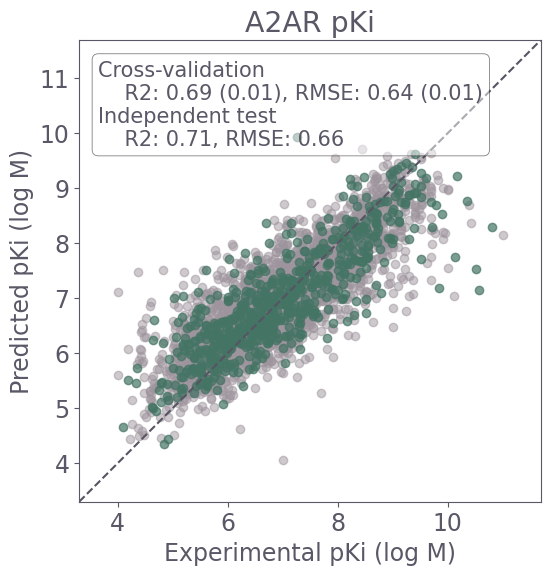

AFE cross-validation: 1.48, independent test: 1.36
GMFE cross-validation: 2.43 (0.04), independent test: 2.50
Within 2-fold cross-validation: 0.57 (0.01), independent test: 0.48


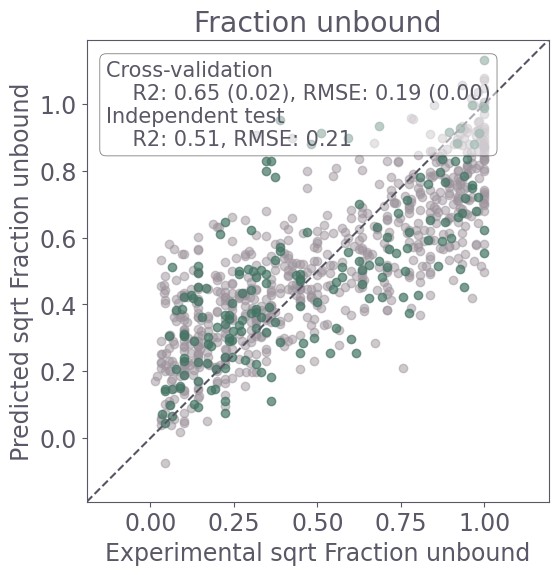

AFE cross-validation: 1.00, independent test: 0.97
GMFE cross-validation: 2.17 (0.02), independent test: 2.32
Within 2-fold cross-validation: 0.54 (0.00), independent test: 0.52


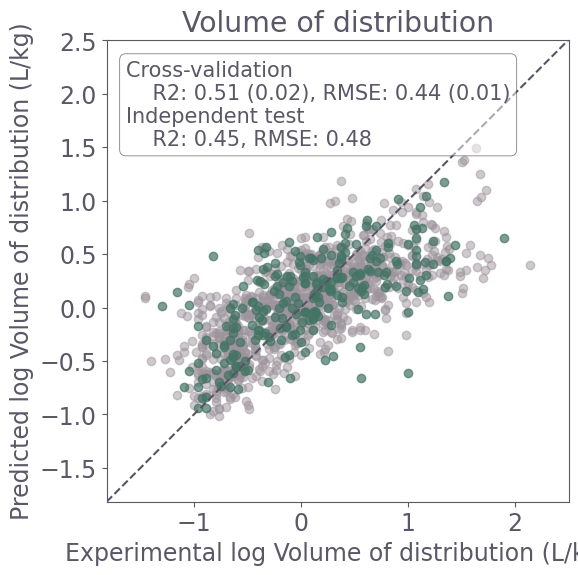

AFE cross-validation: 1.03, independent test: 0.88
GMFE cross-validation: 2.47 (0.08), independent test: 2.46
Within 2-fold cross-validation: 0.49 (0.01), independent test: 0.50


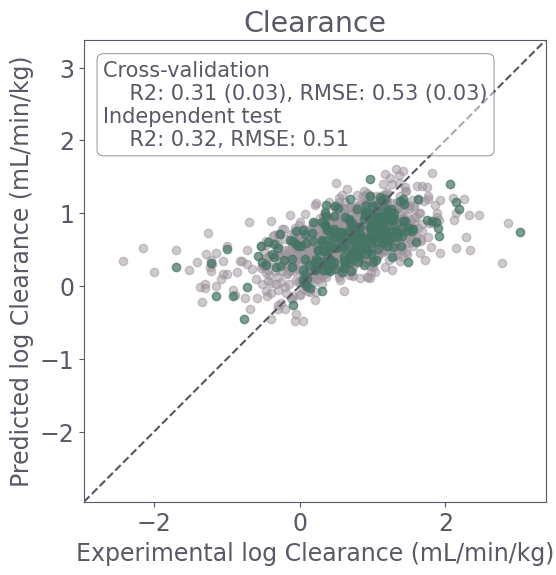

In [10]:
# Create the individual scatter plots for the best models for Figure 2
def scatter_plot(best_model_path, property_name):
    # load in best model
    best_model = QSPRModel.fromFile(best_model_path)

    model_cv = pd.read_csv(f"{best_model.outPrefix}.cv.tsv", sep="\t")
    model_ind = pd.read_csv(f"{best_model.outPrefix}.ind.tsv", sep="\t")

    # Calculate R2 and RMSE
    experimental = f'{property_name}_Label'
    predicted = f'{property_name}_Prediction'

    R2_cv_per_fold = [r2_score(model_cv[model_cv.Fold == i][experimental], model_cv[model_cv.Fold == i][predicted]) for i in model_cv.Fold.unique()]
    R2_cv =  np.mean(R2_cv_per_fold)
    R2_SEM = np.std(R2_cv_per_fold) / np.sqrt(len(R2_cv_per_fold))
    RMSE_cv_per_fold = [root_mean_squared_error(model_cv[model_cv.Fold == i][experimental], model_cv[model_cv.Fold == i][predicted]) for i in model_cv.Fold.unique()]
    RMSE_cv = np.mean(RMSE_cv_per_fold)
    RMSE_SEM = np.std(RMSE_cv_per_fold) / np.sqrt(len(RMSE_cv_per_fold))
    R2_ind =  r2_score(model_ind[experimental], model_ind[predicted])
    RMSE_ind = root_mean_squared_error(model_ind[experimental], model_ind[predicted])
    
    # Calculate AFE, GMFE and within 2-fold
    model_cv_ut = model_cv.copy()
    model_cv_ut[predicted] = 10**model_cv_ut[predicted] if property_name != 'FU' else model_cv_ut[predicted]**2
    model_cv_ut[experimental] = 10**model_cv_ut[experimental] if property_name != 'FU' else model_cv_ut[experimental]**2
    model_ind_ut = model_ind.copy()
    model_ind_ut[predicted] = 10**model_ind_ut[predicted] if property_name != 'FU' else model_ind_ut[predicted]**2
    model_ind_ut[experimental] = 10**model_ind_ut[experimental] if property_name != 'FU' else model_ind_ut[experimental]**2
    
    FE_cv_per_fold = [model_cv_ut[model_cv_ut.Fold == i][predicted] / model_cv_ut[model_cv_ut.Fold == i][experimental] for i in model_cv_ut.Fold.unique()]
    AFE_cv_per_fold = [10**(np.mean(np.log10(i))) for i in FE_cv_per_fold]
    AFE_mean_cv = np.mean(AFE_cv_per_fold)
    FE_ind =  model_ind_ut[predicted] / model_ind_ut[experimental]
    AFE_mean_ind = 10**(np.mean(np.log10(FE_ind)))
    
    GMFE_cv_per_fold = [10**(np.mean(np.absolute(np.log10(i)))) for i in FE_cv_per_fold]
    GMFE_cv = np.mean(GMFE_cv_per_fold)
    GMFE_SEM = np.std(GMFE_cv_per_fold) / np.sqrt(len(GMFE_cv_per_fold))
    GMFE_ind = 10**(np.mean(np.absolute(np.log10(FE_ind))))
    
    within2fold_cv_per_fold = [np.sum(np.abs(np.log10(i)) < np.log10(2)) / len(i) for i in FE_cv_per_fold]
    within2fold_cv = np.mean(within2fold_cv_per_fold)
    within2fold_SEM = np.std(within2fold_cv_per_fold) / np.sqrt(len(within2fold_cv_per_fold))
    within2fold_ind = np.sum(np.abs(np.log10(FE_ind)) < np.log10(2)) / len(FE_ind)
    print(f"AFE cross-validation: {AFE_mean_cv:.2f}, independent test: {AFE_mean_ind:.2f}")
    print(f"GMFE cross-validation: {GMFE_cv:.2f} ({GMFE_SEM:.2f}), independent test: {GMFE_ind:.2f}")
    print(f"Within 2-fold cross-validation: {within2fold_cv:.2f} ({within2fold_SEM:.2f}), independent test: {within2fold_ind:.2f}")

    # scatter plot of predicted vs actual
    plt.figure(figsize=(6.5, 6))
    plt.gca().set_aspect('equal')
    plt.scatter(model_cv[experimental], model_cv[predicted], color=a2arcolors[4], alpha=0.5, label='Cross-Validation')
    plt.scatter(model_ind[experimental], model_ind[predicted], color=a2arcolors[2], alpha=0.7, label='Independent Test')
    plt.legend().remove()

    min_value = min(model_cv[experimental].min(), model_cv[predicted].min())
    max_value = max(model_cv[experimental].max(), model_cv[predicted].max())
    margin = (max_value - min_value) * 0.1
    plt.xlim(min_value - margin, max_value + margin)
    plt.ylim(min_value - margin, max_value + margin)
    plt.plot([min_value - margin, max_value + margin],
             [min_value - margin, max_value + margin],
             color=a2arcolors[3], linestyle='--')
    plt.text(
        min_value-margin*1/2, max_value-margin*3.5/2,
        f"Cross-validation \n    R2: {R2_cv:.2f} ({R2_SEM:.2f}), "
        f"RMSE: {RMSE_cv:.2f} ({RMSE_SEM:.2f})"
        f"\nIndependent test \n    R2: {R2_ind:.2f}, RMSE: {RMSE_ind:.2f}",
        fontsize=15,
        bbox=dict(facecolor='white', alpha=0.5, linewidth=0.6, edgecolor='black', boxstyle='round')
    )
    
    property_name_axis_dict = {
        'A2AR': 'pKi (log M)',
        'CL': 'log Clearance (mL/min/kg)',
        'FU': 'sqrt Fraction unbound',
        'VDSS': 'log Volume of distribution (L/kg)'
    }
    property_name_title_dict = {
        'A2AR': 'A2AR pKi',
        'CL': 'Clearance',
        'FU': 'Fraction unbound',
        'VDSS': 'Volume of distribution'
    }
    
    plt.xlabel(f'Experimental {property_name_axis_dict[property_name]}')
    plt.ylabel(f'Predicted {property_name_axis_dict[property_name]}')
    plt.title(f'{property_name_title_dict[property_name]}')

    plt.savefig(join(QSPR_FIGURES_PATH, 'best_model_performance', f'{best_model.name}_scatter.png'), dpi=400)
    plt.show()

os.makedirs(join(QSPR_FIGURES_PATH, 'best_model_performance'), exist_ok=True)
scatter_plot(best_model_A2AR_path, 'A2AR')
scatter_plot(best_model_FU_path, 'FU')
scatter_plot(best_model_VDSS_path, 'VDSS')
scatter_plot(best_model_CL_path, 'CL')

In [11]:
# Combine the scatter plots into one figure (Figure 2)
best_model_figures_path = join(QSPR_FIGURES_PATH, 'best_model_performance')

model_name_fu = best_model_FU_path.split('/')[-1].removesuffix('_meta.json')
image_path_fu = join(best_model_figures_path, f'{model_name_fu}_scatter.png')
model_name_vdss = best_model_VDSS_path.split('/')[-1].removesuffix('_meta.json')
image_path_vdss = join(best_model_figures_path, f'{model_name_vdss}_scatter.png')
model_name_cl = best_model_CL_path.split('/')[-1].removesuffix('_meta.json')
image_path_cl = join(best_model_figures_path, f'{model_name_cl}_scatter.png')
model_name_a2ar = best_model_A2AR_path.split('/')[-1].removesuffix('_meta.json')
image_path_a2ar = join(best_model_figures_path, f'{model_name_a2ar}_scatter.png')
image_paths = [image_path_a2ar, image_path_fu, image_path_vdss, image_path_cl]
images = [Image.open(x) for x in image_paths]

# add subplot character (A, B, C, D)
for idx, image in enumerate(images):
    draw = ImageDraw.Draw(image)
    draw.text((15, 15), chr(65 + idx), ImageColor.getcolor(COLOR, "RGB"), font=ImageFont.load_default(size=200))

width, height = images[0].size

# Create canvas for the final image with total size
shape = (2, 2)
image_size = (width * shape[1], height * shape[0])
image = Image.new('RGB', image_size)

# Paste images into final image
for row in range(shape[0]):
    for col in range(shape[1]):
        offset = width * col, height * row
        idx = row * shape[1] + col
        image.paste(images[idx], offset)

image.save(join(best_model_figures_path, 'all_scatter_plots.png'), dpi=(300, 300))

## Analyze applicability domain

Plots visualizing the applicability domain of the best model:

* Plot of the bootstrapping test set performance for test set inliers, outliers and all samples for all targets combined (Figure 3 in the manuscript)
* Plots and tables of the bootstrapping test set performance for test set inliers, outliers and all samples for all individual targets (Not included in manuscript)

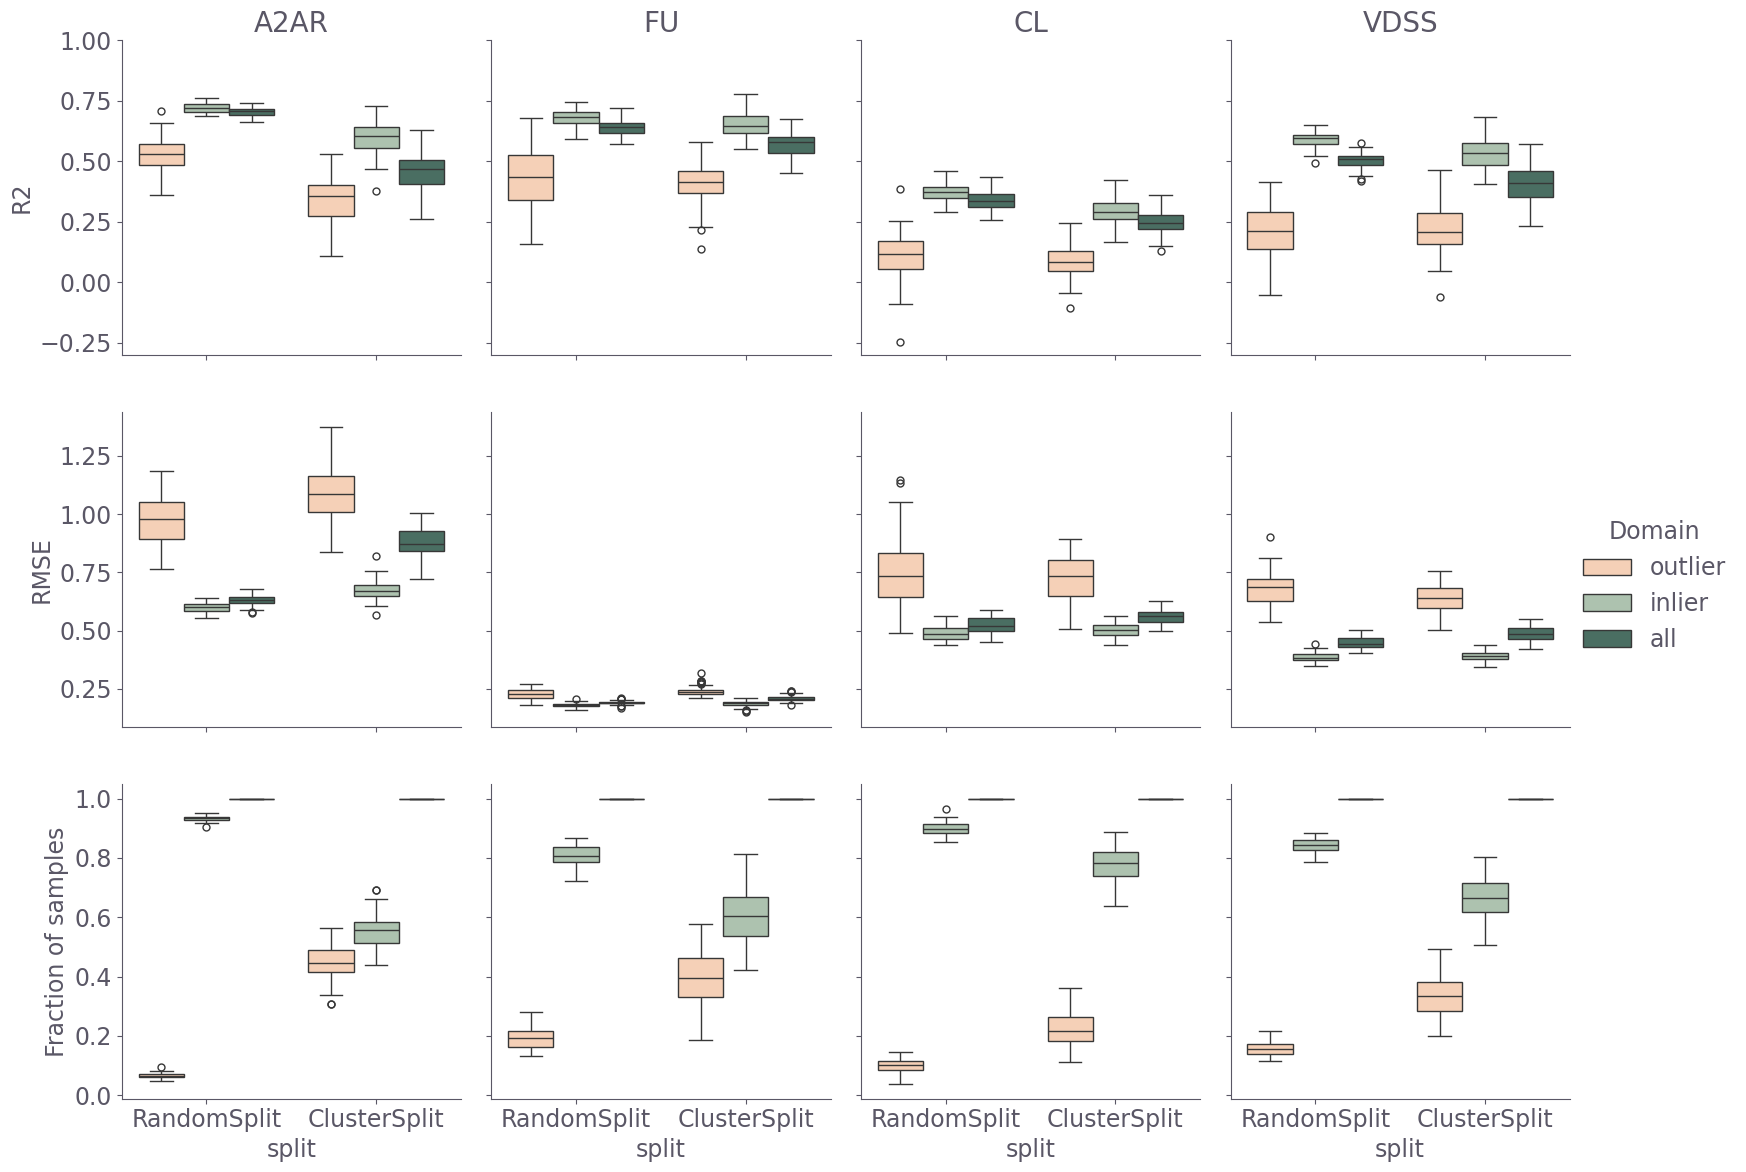

In [12]:
# Plots and tables of the bootstrapping test set performance for test set inliers, outliers and all samples for all individual targets (Figure 3)
applicability_dict = {}
for property_name in ['A2AR', 'FU', 'VDSS', 'CL']:
    applicability_dict[property_name] = pd.read_csv(join(QSPR_PATH, f"bootstrapping_{property_name}/applicability_domain_bootstrapping.tsv"), sep="\t")


applicability_df = pd.concat(applicability_dict.values(), keys=applicability_dict.keys()).reset_index(level=0).rename(columns={'level_0': 'Property'})
applicability_df = applicability_df.rename(columns={'num_samples': 'Number of samples'})

# Calculate fraction of samples
samples_df = applicability_df.pivot_table(index=['ReplicaFile', "split", "Property"], columns="Domain", values="Number of samples")
samples_df["inlier"] = samples_df["inlier"] / samples_df["all"]
samples_df["outlier"] = samples_df["outlier"] / samples_df["all"]
samples_df["all"] = samples_df["all"] / samples_df["all"]

samples_df = samples_df.melt(value_vars=['inlier', 'outlier', 'all'], var_name='Domain', value_name='Number of samples', ignore_index=False)
samples_df = samples_df.set_index('Domain', append=True)

applicability_df.set_index(['ReplicaFile', 'split', 'Property', 'Domain'], inplace=True)
applicability_df = applicability_df.merge(samples_df, left_index=True, right_index=True)
applicability_df.rename(columns={'Number of samples_x': 'Number of samples', 'Number of samples_y': 'Fraction of samples'}, inplace=True)


# melt applicability domain results
applicability_df = applicability_df.reset_index()
applicability_df = applicability_df.melt(id_vars=['ReplicaFile', 'Property', 'split', 'Domain'], value_vars=['R2', 'RMSE', 'Fraction of samples'], var_name='Metric', value_name='Score')

g = sns.catplot(
    applicability_df, x='split', y='Score', hue='Domain', kind='box', col='Property',
    row='Metric', sharey='row', col_order=["A2AR", "FU", "CL", "VDSS"],
    height=4, aspect=1
)	

for ax in g.axes.flatten():
    if 'R2' in ax.get_title():
        ax.set_ylim(None, 1)

    # set y-axis label to the metric
    ax.set_ylabel(ax.get_title().split(' | ')[0].removeprefix('Metric = '))
    
    # if first row set title to the property
    if 'R2' in ax.get_title():
        ax.set_title(ax.get_title().split(' | ')[1].removeprefix('Property = '), size=20)
    else:
        ax.set_title('')


# show plot
plt.savefig(join(QSPR_FIGURES_PATH, 'ap_domain', 'applicability_domain_boxplot.png'), bbox_inches='tight')
plt.show()
    

A2AR


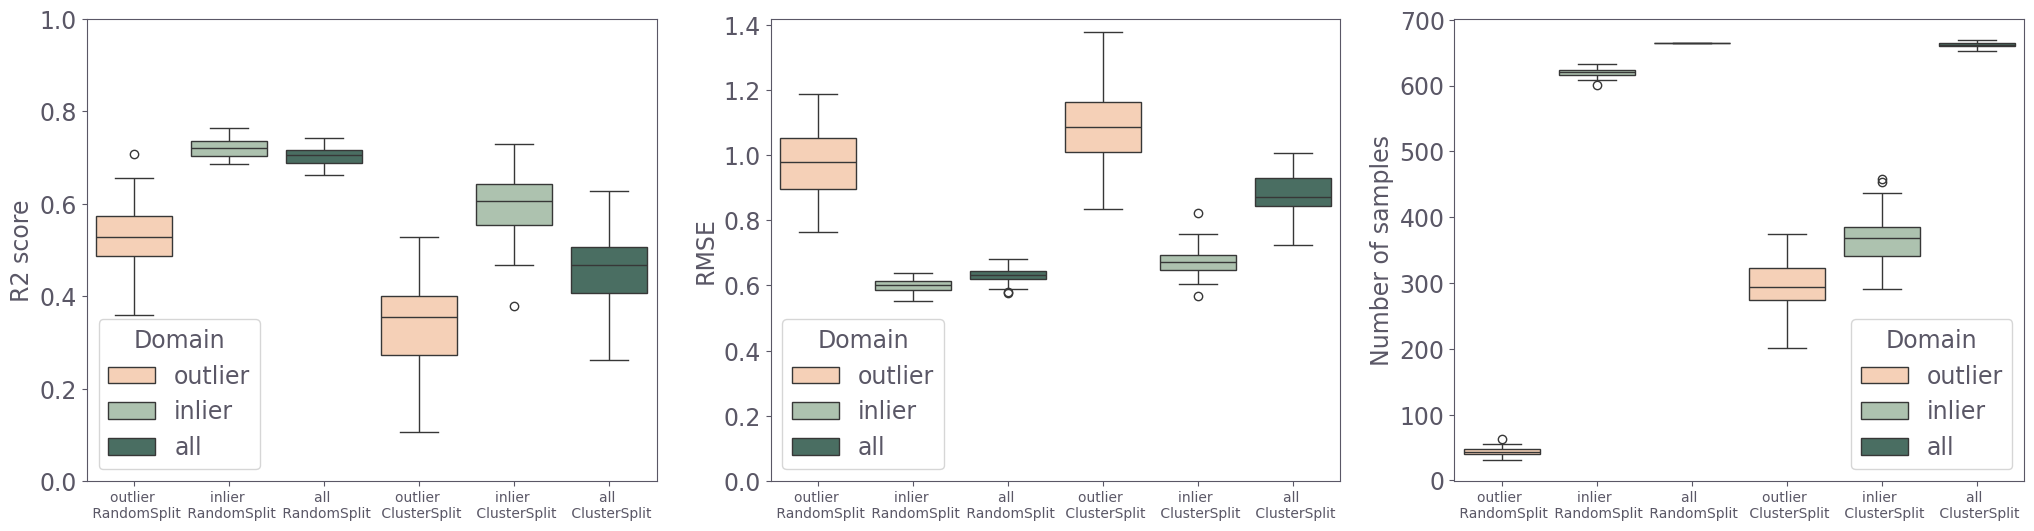

R2                                    RMSE  \
                          mean       std       min       max      mean   
split        Domain                                                      
ClusterSplit all      0.459096  0.074130  0.263151  0.627525  0.881016   
             inlier   0.596948  0.066771  0.378773  0.729465  0.673400   
             outlier  0.337505  0.101955  0.107226  0.528070  1.084525   
RandomSplit  all      0.704771  0.019553  0.662024  0.742524  0.631615   
             inlier   0.721901  0.020302  0.686586  0.763381  0.599161   
             outlier  0.533883  0.067025  0.360200  0.708186  0.974384   

                                                   num_samples  
                           std       min       max        mean  
split        Domain                                             
ClusterSplit all      0.065970  0.723222  1.006872      661.66  
             inlier   0.045250  0.568629  0.820833      367.92  
             outlier  0.103947  0.835578  1.375966      293.74  
RandomSplit  all      0.023269  0.575898  0.680633      664.00  
             inlier   0.020776  0.553253  0.639020      619.80  
             outlier  0.105189  0.765119  1.187547       44.20

FU


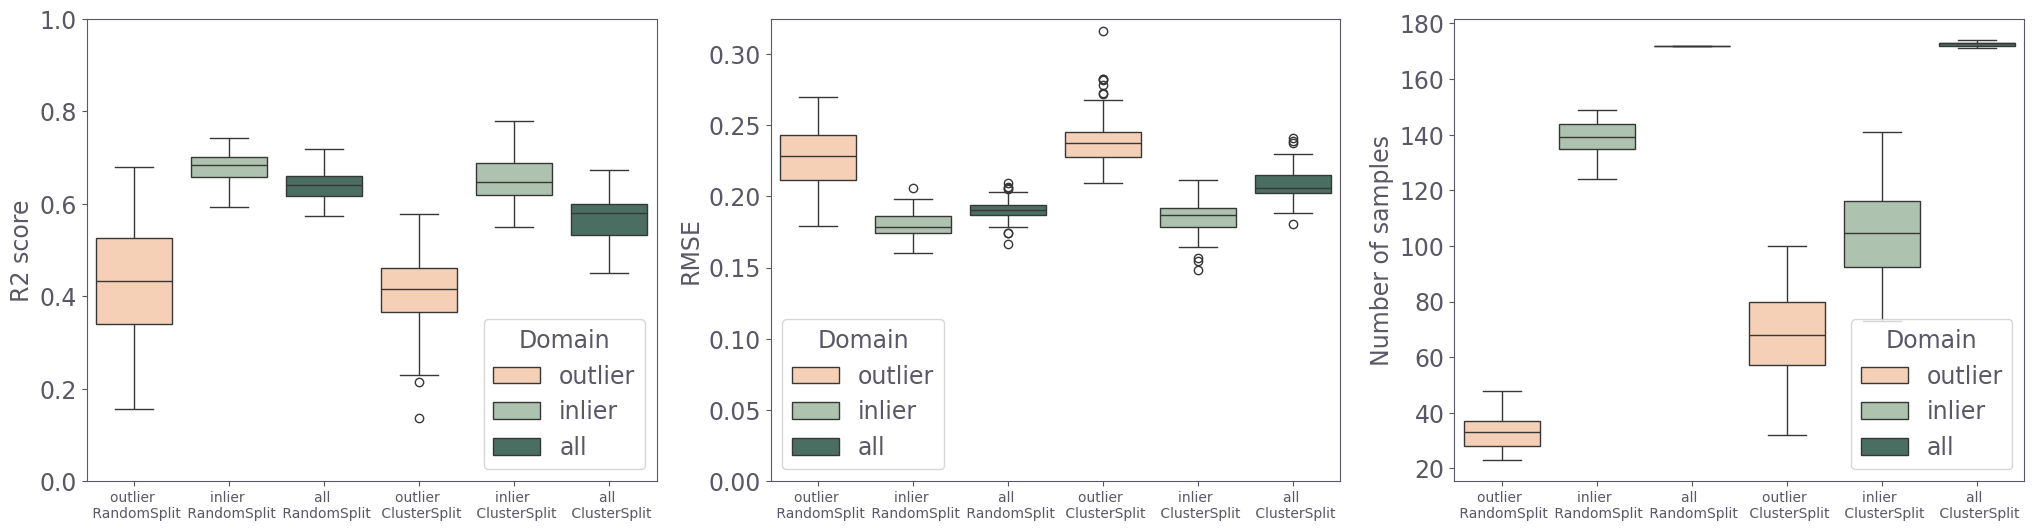

R2                                    RMSE  \
                          mean       std       min       max      mean   
split        Domain                                                      
ClusterSplit all      0.565455  0.050795  0.449913  0.672998  0.209190   
             inlier   0.654869  0.050526  0.549860  0.780115  0.184891   
             outlier  0.404994  0.088437  0.137564  0.577955  0.241279   
RandomSplit  all      0.637589  0.031462  0.572781  0.718995  0.190428   
             inlier   0.679049  0.035941  0.592395  0.743235  0.179959   
             outlier  0.429723  0.115567  0.156159  0.680815  0.228415   

                                                   num_samples  
                           std       min       max        mean  
split        Domain                                             
ClusterSplit all      0.012525  0.180937  0.241007      172.90  
             inlier   0.013411  0.148410  0.211496      105.54  
             outlier  0.021377  0.209211  0.316187       67.36  
RandomSplit  all      0.008436  0.166865  0.209714      172.00  
             inlier   0.009551  0.160283  0.206223      139.10  
             outlier  0.021151  0.179332  0.269736       32.90

VDSS


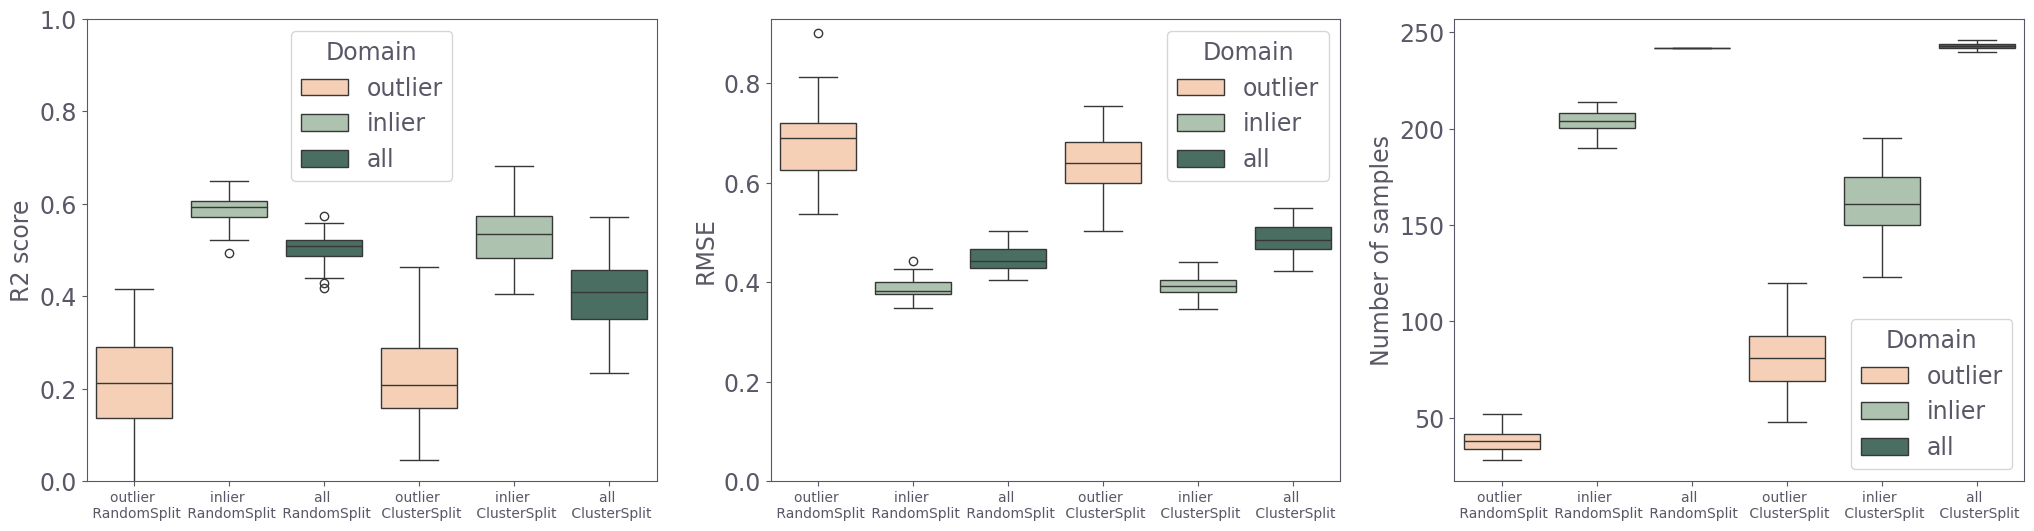

R2                                    RMSE  \
                          mean       std       min       max      mean   
split        Domain                                                      
ClusterSplit all      0.404346  0.072636  0.233064  0.572543  0.488033   
             inlier   0.531756  0.065402  0.403916  0.682141  0.391390   
             outlier  0.223107  0.095126 -0.060603  0.462864  0.642155   
RandomSplit  all      0.505695  0.032788  0.417004  0.574776  0.446616   
             inlier   0.588070  0.033347  0.492737  0.649775  0.386747   
             outlier  0.208918  0.102805 -0.054181  0.415153  0.681431   

                                                   num_samples  
                           std       min       max        mean  
split        Domain                                             
ClusterSplit all      0.031372  0.421577  0.549793      242.72  
             inlier   0.023145  0.345027  0.439598      163.42  
             outlier  0.061154  0.502044  0.754265       79.30  
RandomSplit  all      0.024335  0.404121  0.502053      242.00  
             inlier   0.020052  0.348409  0.441883      203.94  
             outlier  0.066317  0.537390  0.901094       38.06

CL


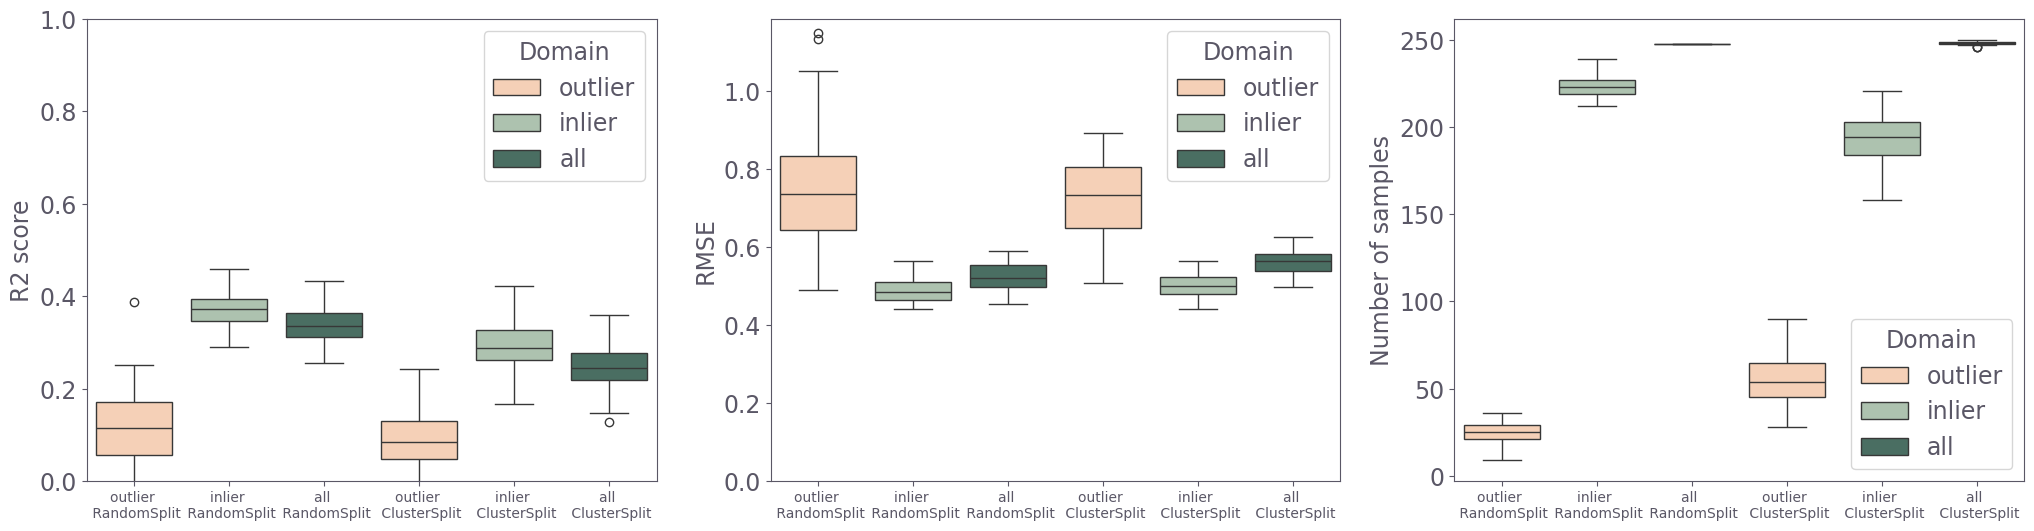

R2                                    RMSE  \
                          mean       std       min       max      mean   
split        Domain                                                      
ClusterSplit all      0.246405  0.047253  0.127608  0.360435  0.560847   
             inlier   0.290614  0.053629  0.166357  0.421358  0.503091   
             outlier  0.086919  0.066842 -0.108933  0.243452  0.727521   
RandomSplit  all      0.338766  0.042389  0.256303  0.432824  0.519535   
             inlier   0.373305  0.038971  0.290081  0.457962  0.487133   
             outlier  0.101957  0.106421 -0.248530  0.386643  0.744056   

                                                   num_samples  
                           std       min       max        mean  
split        Domain                                             
ClusterSplit all      0.032122  0.496753  0.625195      248.40  
             inlier   0.029528  0.440004  0.563245      193.24  
             outlier  0.096261  0.506858  0.892270       55.16  
RandomSplit  all      0.036569  0.452408  0.589021      248.00  
             inlier   0.029063  0.439934  0.564585      222.90  
             outlier  0.148702  0.489505  1.147857       25.10

In [13]:
# Individual plots of bootstrapping test set performance for test set inliers, outliers and all samples (not in manuscript)
for property_name in ['A2AR', 'FU', 'VDSS', 'CL']:
    print(property_name)

    applicabiltiliy_df = pd.read_csv(join(QSPR_PATH, f"bootstrapping_{property_name}/applicability_domain_bootstrapping.tsv"), sep="\t")

    # combine split and Domain into one colum
    applicabiltiliy_df['Split_Domain'] = applicabiltiliy_df.apply(lambda x: f"{x.Domain} \n {x.split}", axis=1)

    fig, ax = plt.subplots(1, 3, figsize=(25, 6))
    sns.boxplot(data=applicabiltiliy_df, x='Split_Domain', y='R2', ax=ax[0], hue='Domain')
    ax[0].set_ylim(0, 1)
    ax[0].set_ylabel('R2 score')
    ax[0].set_xlabel('')
    ax[0].tick_params(axis='x', labelsize=10)
    sns.boxplot(data=applicabiltiliy_df, x='Split_Domain', y='RMSE', ax=ax[1], hue='Domain')
    ax[1].set_ylabel('RMSE')
    ax[1].set_xlabel('')
    ax[1].tick_params(axis='x', labelsize=10)
    sns.boxplot(data=applicabiltiliy_df, x='Split_Domain', y='num_samples', ax=ax[2], hue='Domain')
    ax[2].set_ylabel('Number of samples')
    ax[2].set_xlabel('')
    ax[2].tick_params(axis='x', labelsize=10)
    ax[1].set_ylim(0, None)
    plt.savefig(join(QSPR_FIGURES_PATH, 'ap_domain', f'bootstrapping_{property_name}_ad_r2_rmse_boxplot.png'), bbox_inches='tight')
    plt.show()

    # Show average and std of R2 and RMSE for each split and domain
    display(applicabiltiliy_df.groupby(['split', 'Domain']).agg({'R2': ['mean', 'std', 'min', 'max'], 'RMSE': ['mean', 'std', 'min', 'max'], 'num_samples': 'mean'}))

## Analyze the feature importance

Feature importance analysis of the best models:
* Box plots of feature importance of 10 most important features per model (Supplementary Figure S3)
* Images of three random molecules with bit highlighted for important bit features (Supplementary Figure S3)

In [ ]:
# Load in the feature importances
importance_df_A2AR = pd.read_csv(f"{best_model_A2AR_path.removesuffix('_meta.json')}_feature_importance.csv", index_col=0)
print("Feature importance for A2AR")
display(importance_df_A2AR.sort_values(by='importances_mean_r2', ascending=False)[:10])

importance_df_FU = pd.read_csv(f"{best_model_FU_path.removesuffix('_meta.json')}_feature_importance.csv", index_col=0)
print("Feature importance for FU")
display(importance_df_FU.sort_values(by='importances_mean_r2', ascending=False)[:10])

importance_df_VDSS = pd.read_csv(f"{best_model_VDSS_path.removesuffix('_meta.json')}_feature_importance.csv", index_col=0)
print("Feature importance for VDSS")
display(importance_df_VDSS.sort_values(by='importances_mean_r2', ascending=False)[:10])

importance_df_CL = pd.read_csv(f"{best_model_CL_path.removesuffix('_meta.json')}_feature_importance.csv", index_col=0)
print("Feature importance for CL")
display(importance_df_CL.sort_values(by='importances_mean_r2', ascending=False)[:10])

Feature importance for A2AR


importances_mean_r2  importances_std_r2  \
MorganFP_858              0.010208            0.001137   
MorganFP_725              0.006610            0.000717   
MorganFP_409              0.006326            0.000409   
MorganFP_1198             0.005771            0.000585   
MorganFP_1130             0.005615            0.000620   
MorganFP_1717             0.005362            0.000551   
MorganFP_323              0.005227            0.000452   
MorganFP_1789             0.004840            0.000597   
MorganFP_974              0.004590            0.000499   
MorganFP_224              0.004507            0.000511   

               importances_mean_neg_mean_squared_error  \
MorganFP_858                                  0.015377   
MorganFP_725                                  0.009956   
MorganFP_409                                  0.009529   
MorganFP_1198                                 0.008692   
MorganFP_1130                                 0.008458   
MorganFP_1717                                 0.008077   
MorganFP_323                                  0.007873   
MorganFP_1789                                 0.007291   
MorganFP_974                                  0.006914   
MorganFP_224                                  0.006789   

               importances_std_neg_mean_squared_error  
MorganFP_858                                 0.001713  
MorganFP_725                                 0.001080  
MorganFP_409                                 0.000617  
MorganFP_1198                                0.000881  
MorganFP_1130                                0.000934  
MorganFP_1717                                0.000829  
MorganFP_323                                 0.000681  
MorganFP_1789                                0.000900  
MorganFP_974                                 0.000752  
MorganFP_224                                 0.000769

Feature importance for FU


importances_mean_r2  importances_std_r2  \
MorganFP_202              0.015919            0.004449   
SlogP_VSA4                0.011709            0.003617   
MolLogP                   0.011251            0.004083   
MorganFP_1056             0.009031            0.001235   
MorganFP_27               0.008879            0.002638   
PEOE_VSA6                 0.008574            0.003161   
PEOE_VSA4                 0.008287            0.001729   
fr_quatN                  0.007802            0.002067   
HallKierAlpha             0.007312            0.002869   
MorganFP_1738             0.007287            0.002279   

               importances_mean_neg_mean_squared_error  \
MorganFP_202                                  0.001434   
SlogP_VSA4                                    0.001055   
MolLogP                                       0.001013   
MorganFP_1056                                 0.000813   
MorganFP_27                                   0.000800   
PEOE_VSA6                                     0.000772   
PEOE_VSA4                                     0.000746   
fr_quatN                                      0.000703   
HallKierAlpha                                 0.000659   
MorganFP_1738                                 0.000656   

               importances_std_neg_mean_squared_error  
MorganFP_202                                 0.000401  
SlogP_VSA4                                   0.000326  
MolLogP                                      0.000368  
MorganFP_1056                                0.000111  
MorganFP_27                                  0.000238  
PEOE_VSA6                                    0.000285  
PEOE_VSA4                                    0.000156  
fr_quatN                                     0.000186  
HallKierAlpha                                0.000258  
MorganFP_1738                                0.000205

Feature importance for VDSS


importances_mean_r2  importances_std_r2  \
MorganFP_126              0.010486            0.002358   
MorganFP_72               0.009941            0.003415   
MorganFP_650              0.009011            0.001818   
fr_ester                  0.008637            0.001751   
MorganFP_155              0.008613            0.002002   
MorganFP_1360             0.008245            0.000669   
MorganFP_1224             0.008151            0.001514   
MorganFP_1777             0.007113            0.001134   
MorganFP_816              0.007056            0.001094   
MorganFP_1361             0.006601            0.001081   

               importances_mean_neg_mean_squared_error  \
MorganFP_126                                  0.004416   
MorganFP_72                                   0.004186   
MorganFP_650                                  0.003794   
fr_ester                                      0.003637   
MorganFP_155                                  0.003627   
MorganFP_1360                                 0.003472   
MorganFP_1224                                 0.003432   
MorganFP_1777                                 0.002995   
MorganFP_816                                  0.002971   
MorganFP_1361                                 0.002780   

               importances_std_neg_mean_squared_error  
MorganFP_126                                 0.000993  
MorganFP_72                                  0.001438  
MorganFP_650                                 0.000766  
fr_ester                                     0.000737  
MorganFP_155                                 0.000843  
MorganFP_1360                                0.000282  
MorganFP_1224                                0.000637  
MorganFP_1777                                0.000478  
MorganFP_816                                 0.000461  
MorganFP_1361                                0.000455

Feature importance for CL


importances_mean_r2  importances_std_r2  \
MorganFP_511              0.022907            0.004374   
MorganFP_1175             0.021000            0.002529   
MorganFP_1389             0.016895            0.005409   
MorganFP_1058             0.015826            0.005025   
MorganFP_126              0.013208            0.002520   
fr_ester                  0.011970            0.003965   
MorganFP_650              0.011237            0.003285   
fr_COO                    0.010868            0.002438   
MorganFP_378              0.008992            0.002210   
MorganFP_145              0.008575            0.002149   

               importances_mean_neg_mean_squared_error  \
MorganFP_511                                  0.008935   
MorganFP_1175                                 0.008191   
MorganFP_1389                                 0.006590   
MorganFP_1058                                 0.006173   
MorganFP_126                                  0.005152   
fr_ester                                      0.004669   
MorganFP_650                                  0.004383   
fr_COO                                        0.004239   
MorganFP_378                                  0.003507   
MorganFP_145                                  0.003344   

               importances_std_neg_mean_squared_error  
MorganFP_511                                 0.001706  
MorganFP_1175                                0.000987  
MorganFP_1389                                0.002110  
MorganFP_1058                                0.001960  
MorganFP_126                                 0.000983  
fr_ester                                     0.001546  
MorganFP_650                                 0.001281  
fr_COO                                       0.000951  
MorganFP_378                                 0.000862  
MorganFP_145                                 0.000838

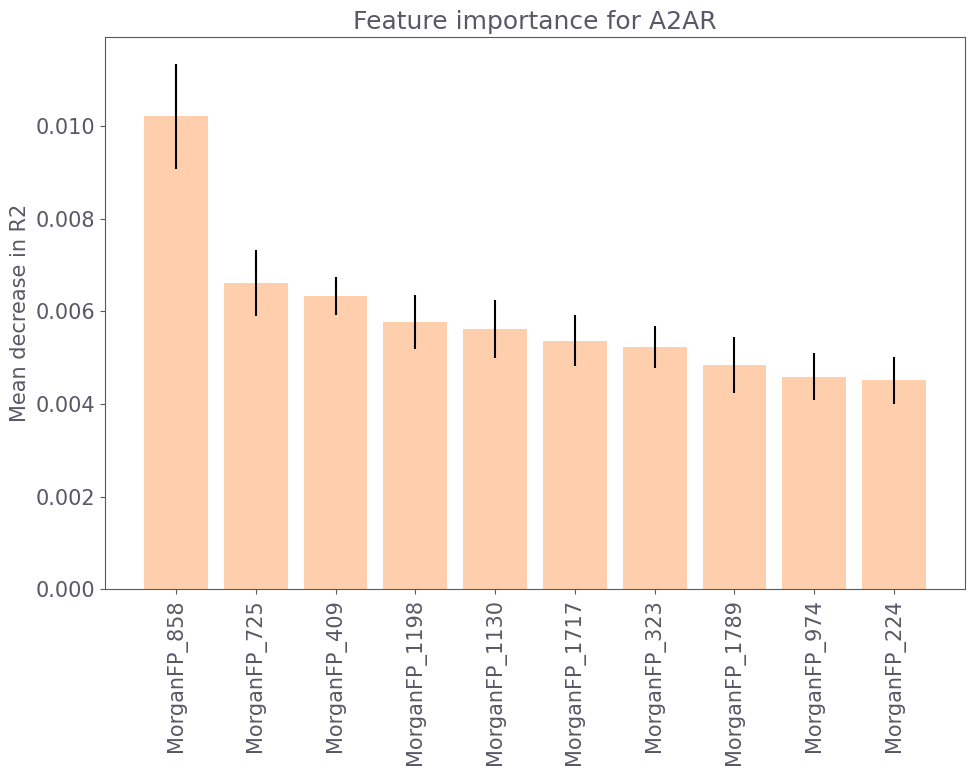

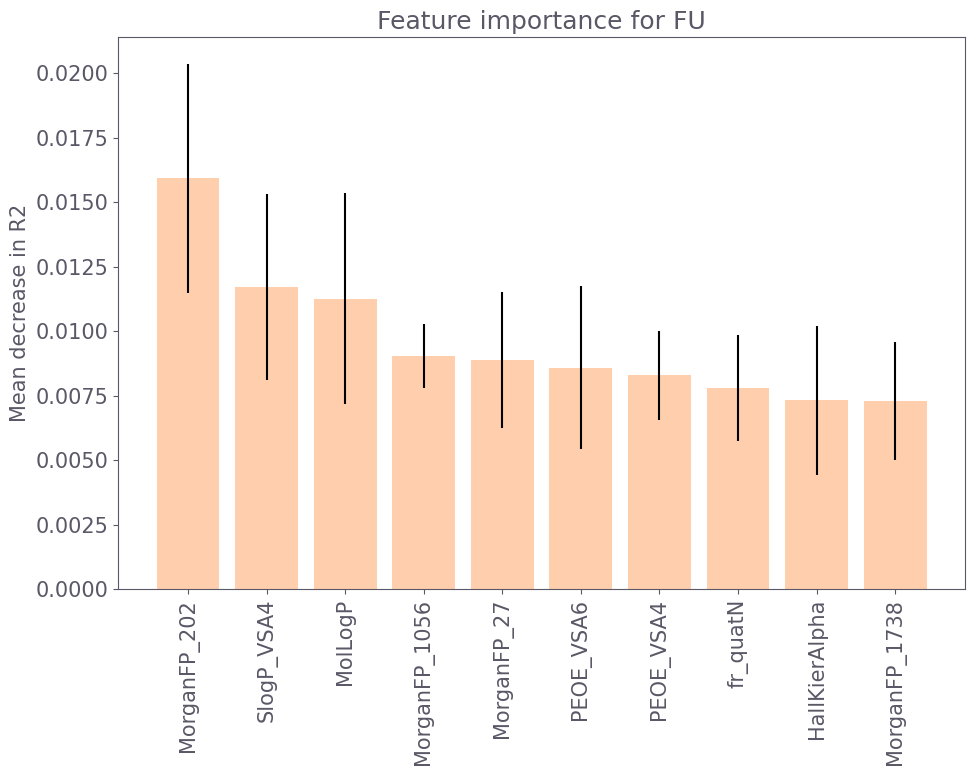

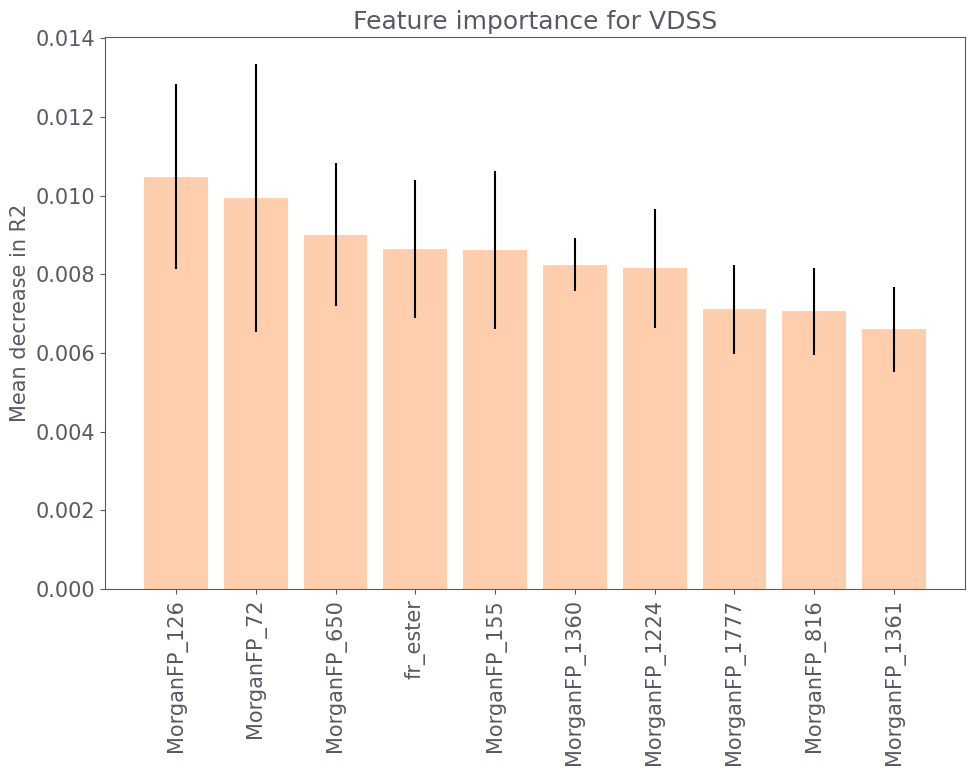

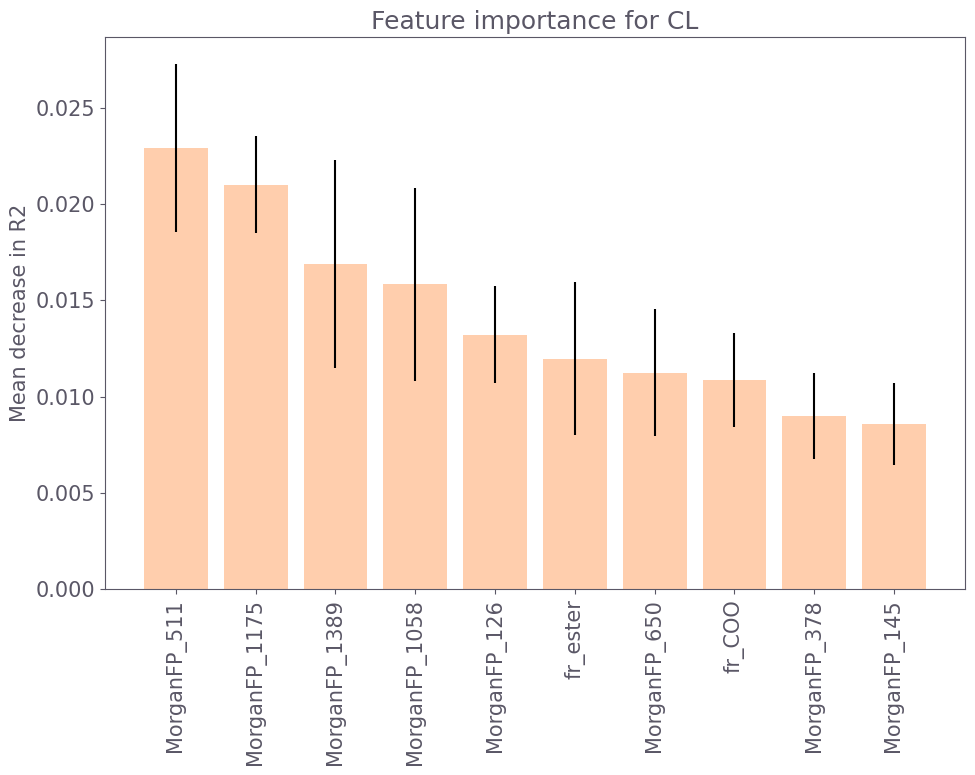

In [ ]:
# Plot the 10 most important features for each target (Supplementary Figure S3)
def feature_importance_plot(importance_df, target_name, best_model_path):
    plt.figure(figsize=(10, 8))
    plt.bar(importance_df.index[:10], importance_df['importances_mean_r2'][:10], yerr=importance_df['importances_std_r2'][:10])
    plt.title(f'Feature importance for {target_name}')
    plt.ylabel('Mean decrease in R2')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(join(QSPR_FIGURES_PATH, "feature_importance", f'{os.path.basename(best_model_path).removesuffix("_meta.json")}_feature_importance.png'), dpi=300)
    plt.show()

os.makedirs(join(QSPR_FIGURES_PATH, 'feature_importance'), exist_ok=True)
feature_importance_plot(importance_df_A2AR, 'A2AR', best_model_A2AR_path)
feature_importance_plot(importance_df_FU, 'FU', best_model_FU_path)
feature_importance_plot(importance_df_VDSS, 'VDSS', best_model_VDSS_path)
feature_importance_plot(importance_df_CL, 'CL', best_model_CL_path)

Dataset average A2AR: 6.98
n = 24 (0.72%), mean A2AR 8.02


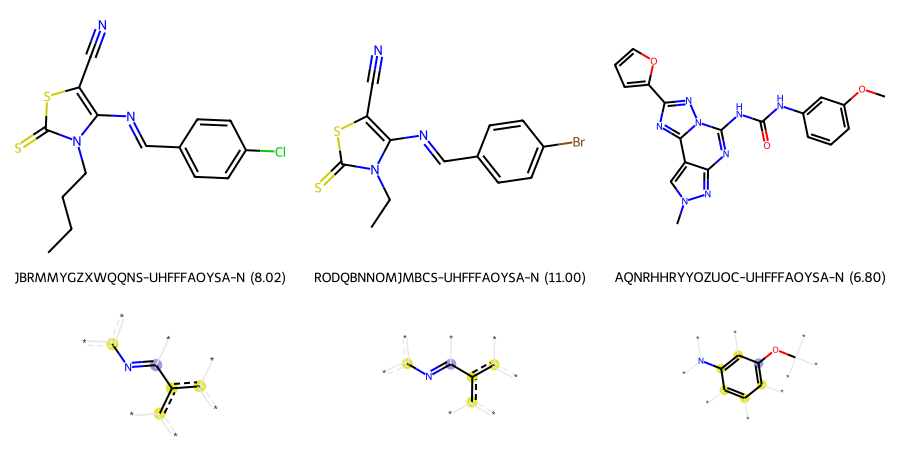

n = 36 (1.08%), mean A2AR 7.58


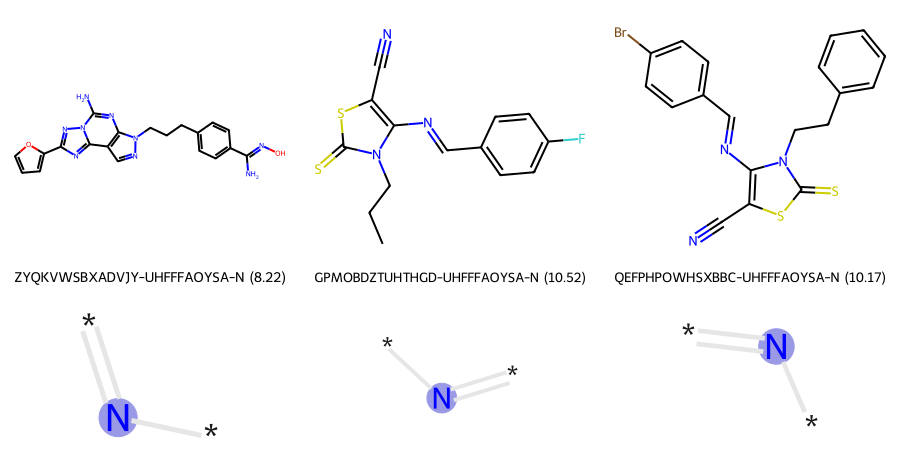

n = 458 (13.80%), mean A2AR 7.79


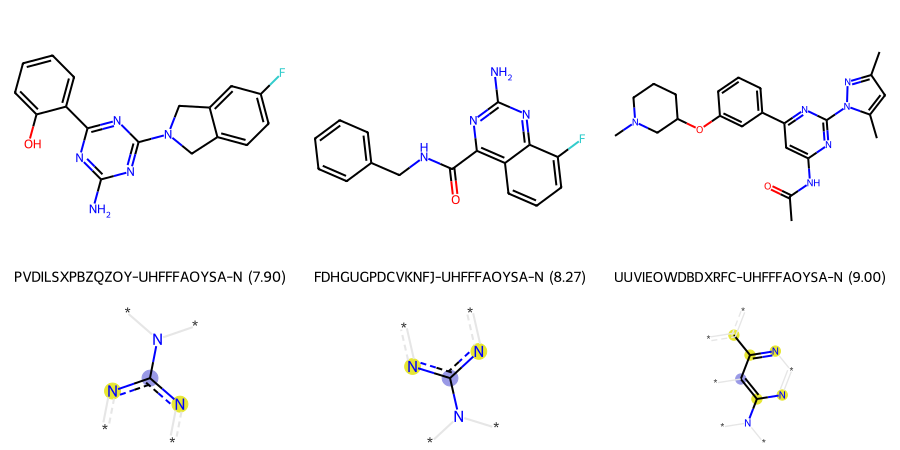

n = 11 (0.33%), mean A2AR 9.20


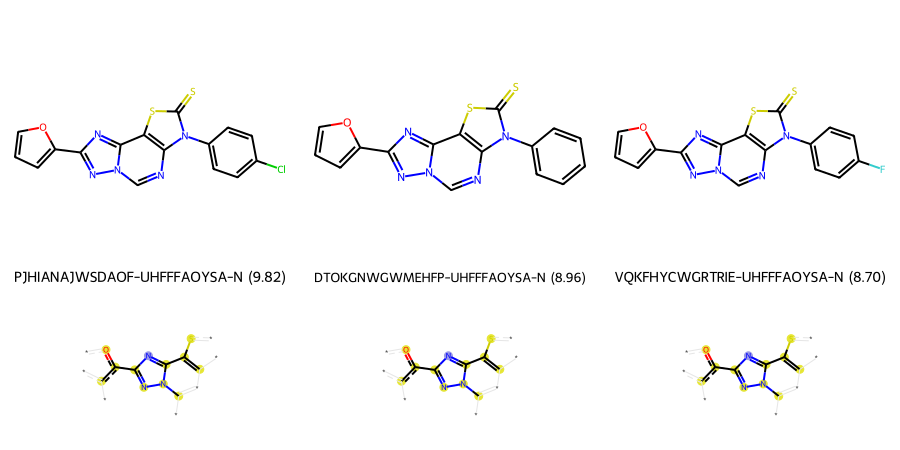

n = 42 (1.27%), mean A2AR 7.61


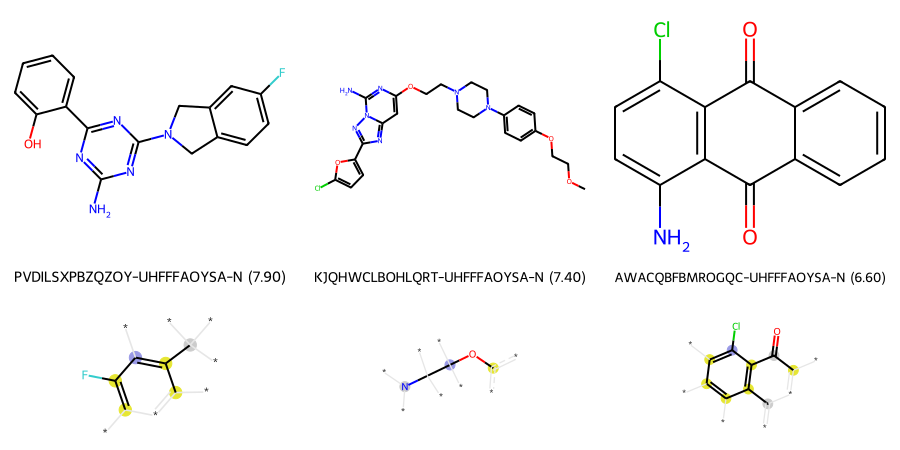

n = 81 (2.44%), mean A2AR 7.61


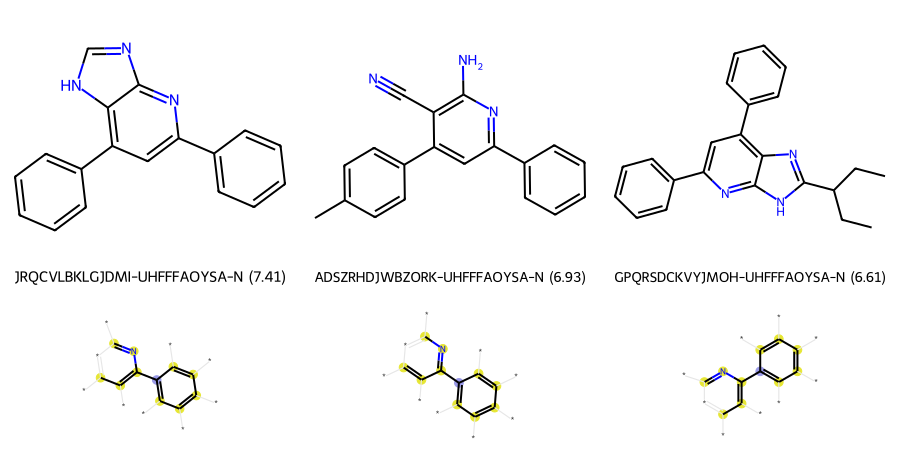

n = 430 (12.96%), mean A2AR 7.38


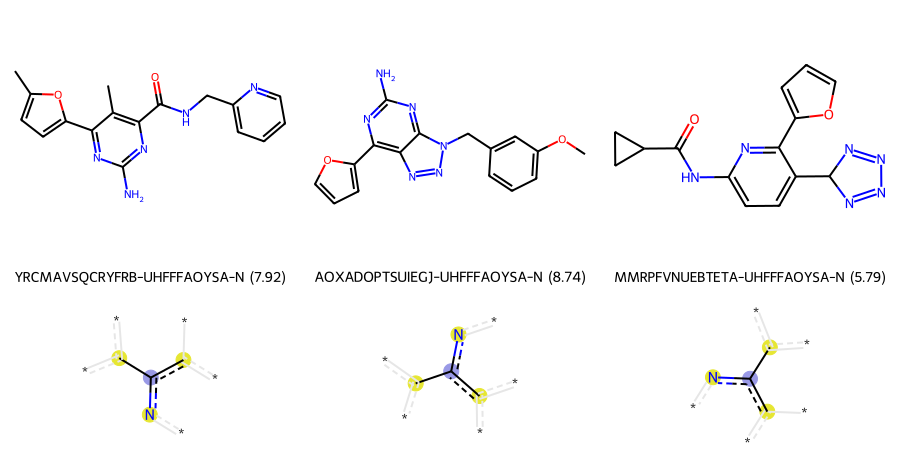

n = 47 (1.42%), mean A2AR 7.33


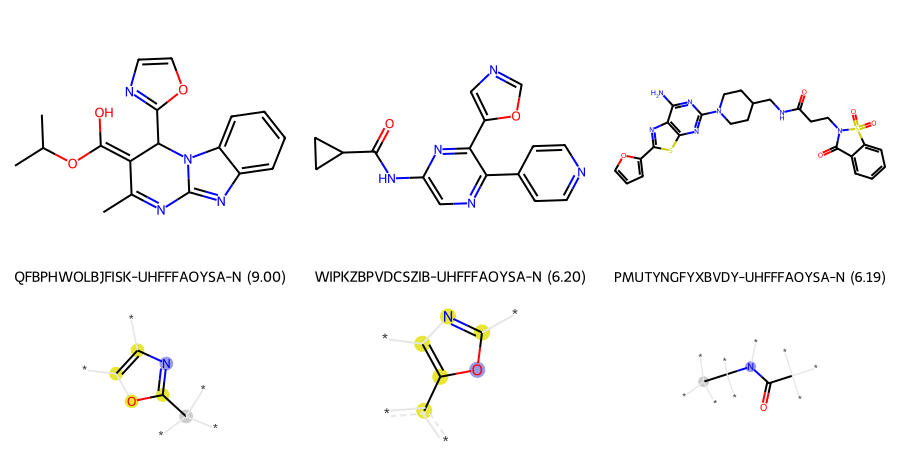

n = 70 (2.11%), mean A2AR 7.04


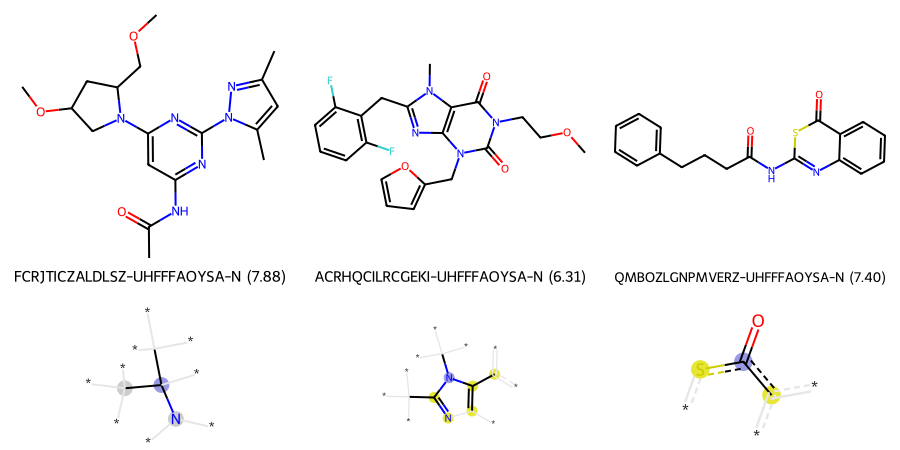

n = 75 (2.26%), mean A2AR 7.34


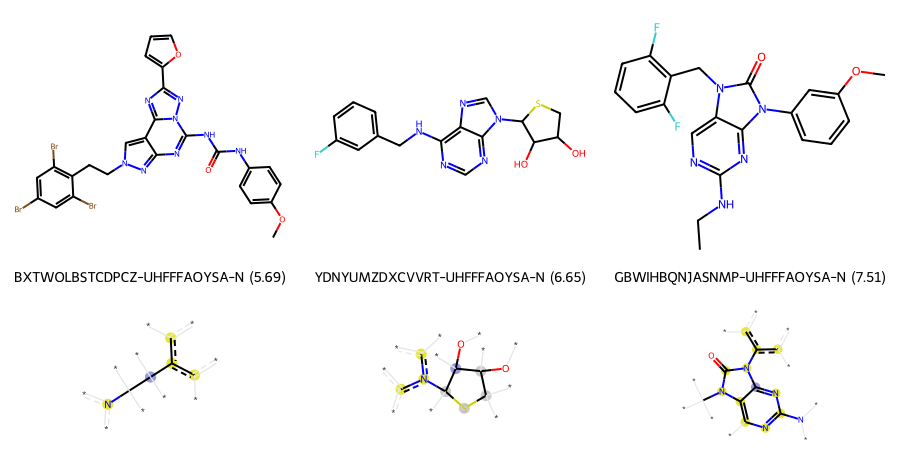

Dataset average FU: 0.50
n = 92 (10.70%), mean FU 0.36


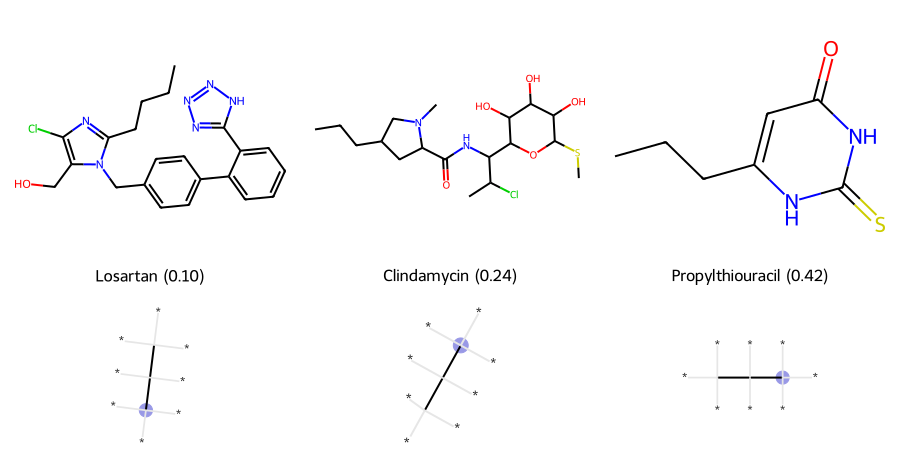

n = 20 (2.33%), mean FU 0.46


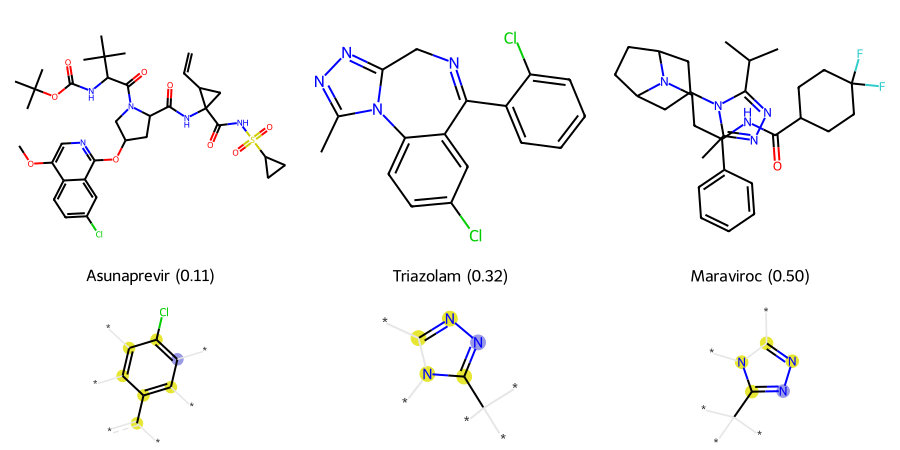

n = 44 (5.12%), mean FU 0.34


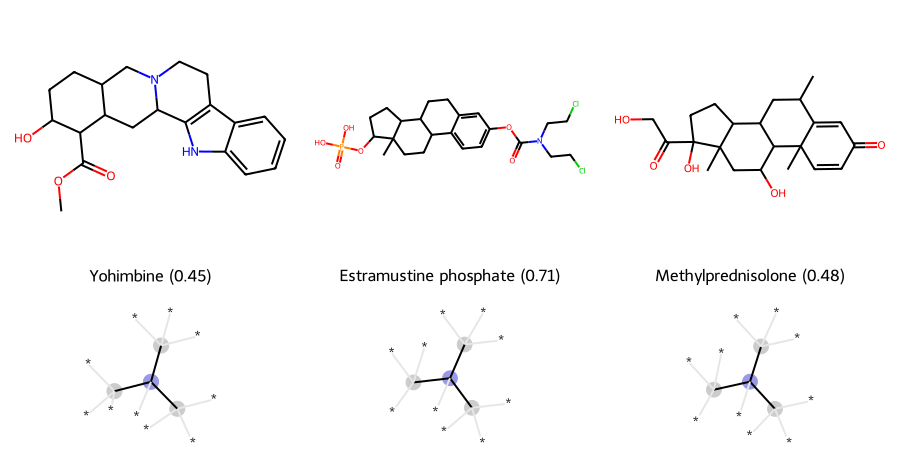

n = 69 (8.02%), mean FU 0.31


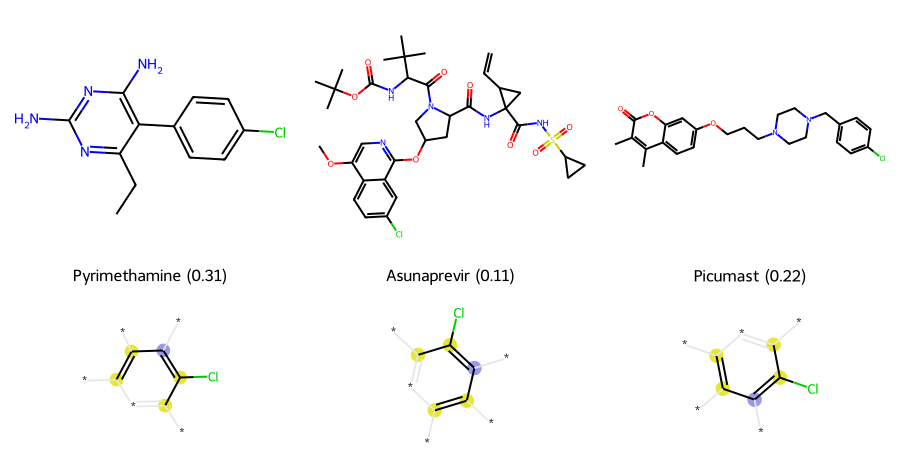

Dataset average VDSS: 0.04
n = 301 (24.94%), mean VDSS -0.41


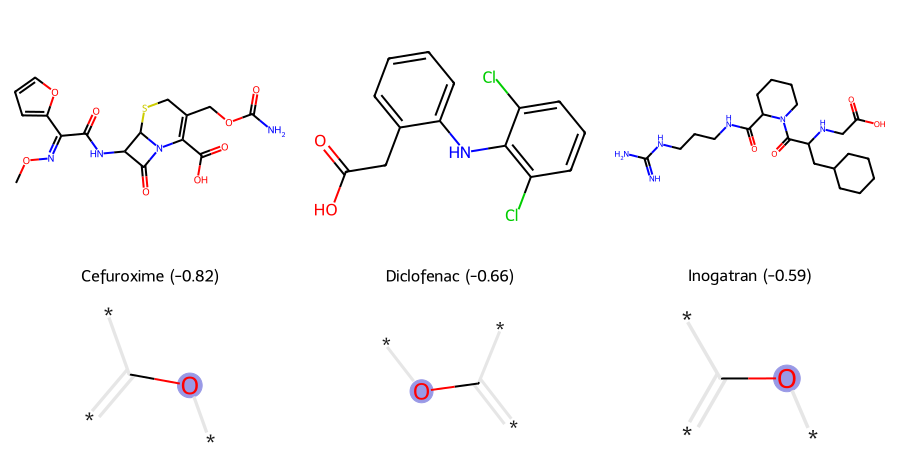

n = 17 (1.41%), mean VDSS 0.40


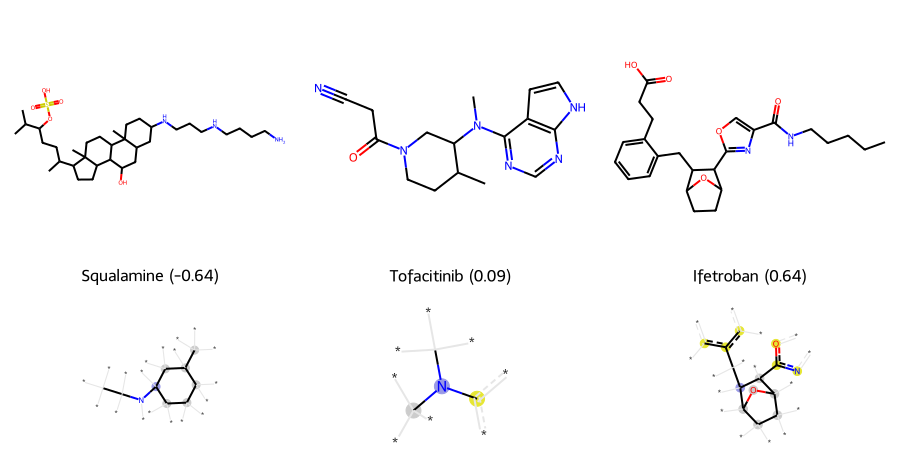

n = 948 (78.54%), mean VDSS -0.06


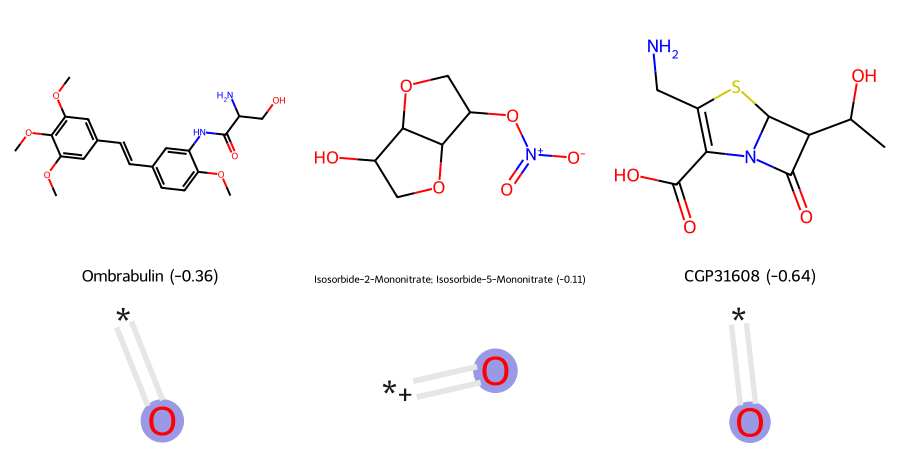

n = 18 (1.49%), mean VDSS 0.64


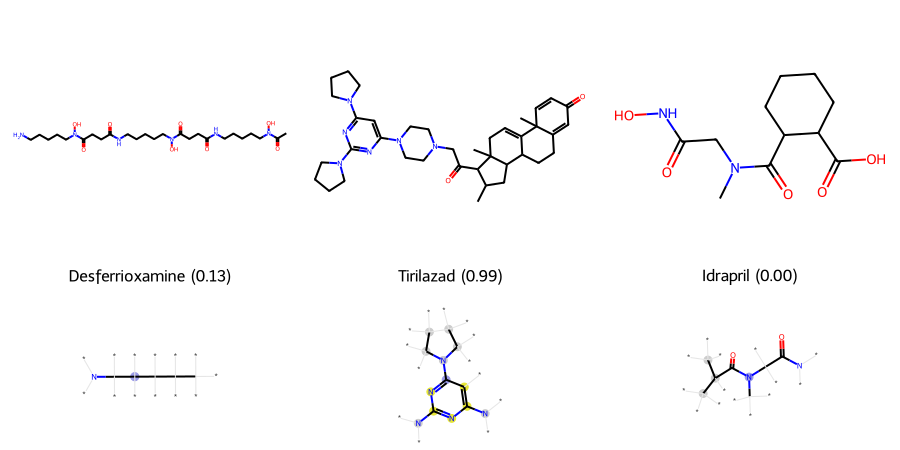

n = 31 (2.57%), mean VDSS 0.59


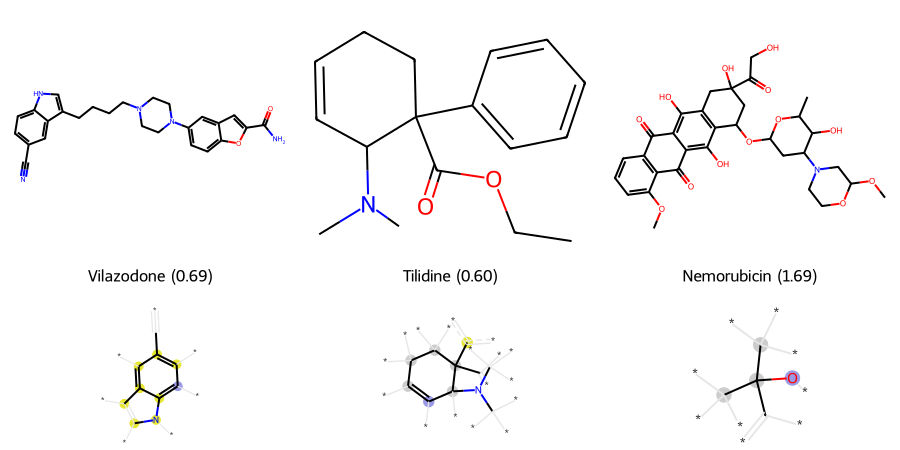

n = 55 (4.56%), mean VDSS 0.31


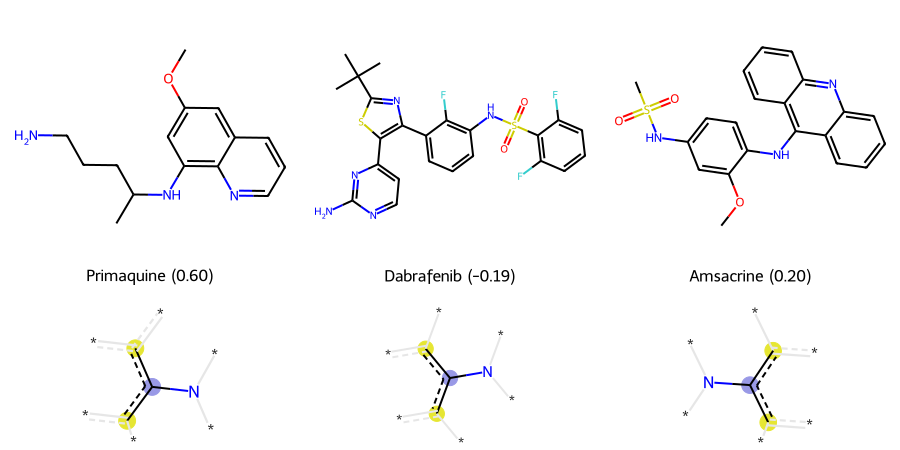

n = 39 (3.23%), mean VDSS 0.64


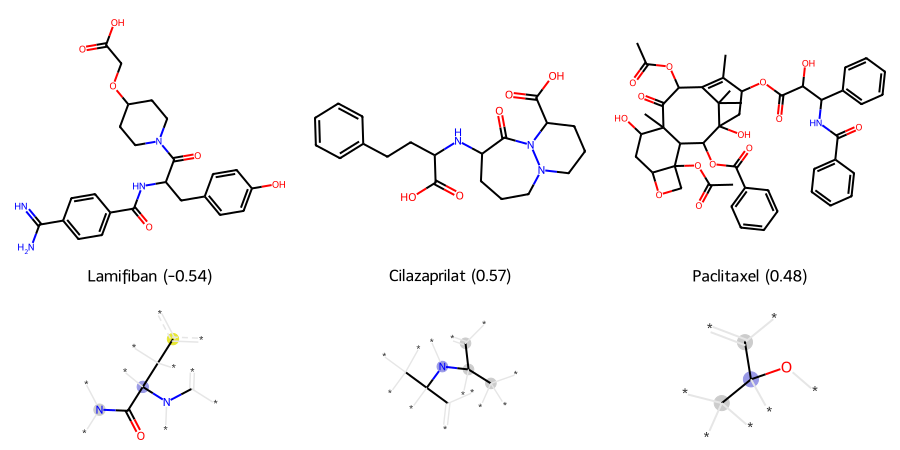

n = 30 (2.49%), mean VDSS 0.41


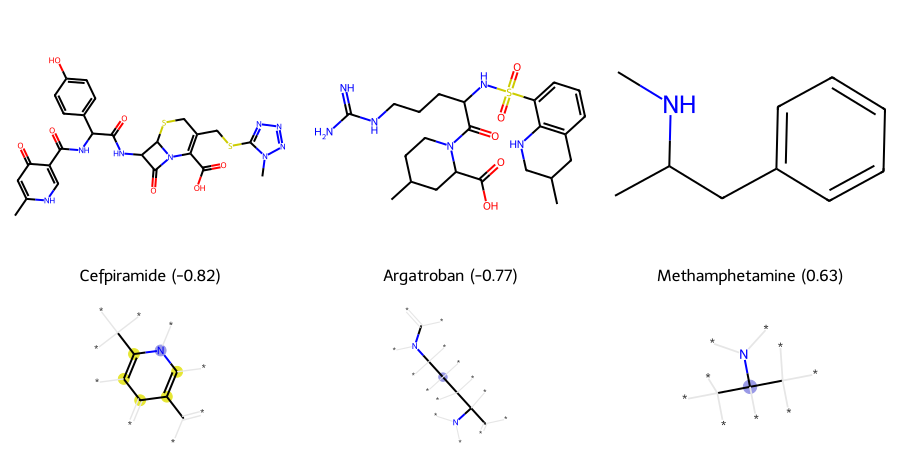

n = 26 (2.15%), mean VDSS 0.38


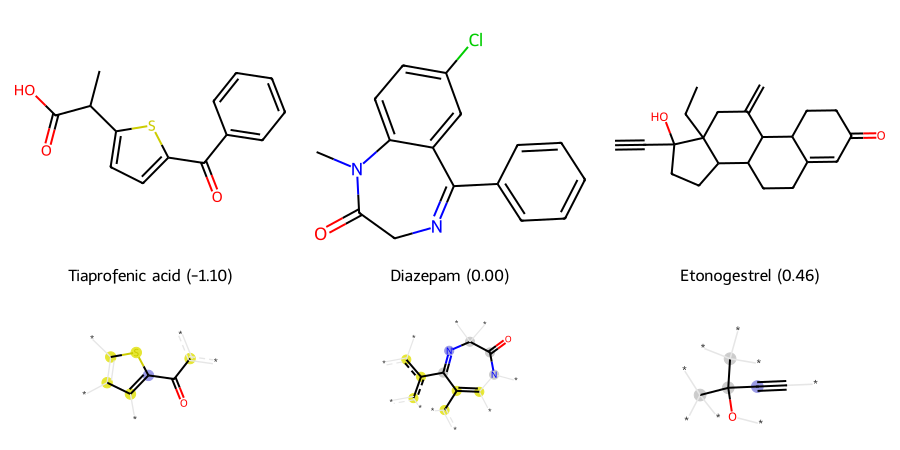

Dataset average CL: 0.63
n = 13 (1.05%), mean CL -0.30


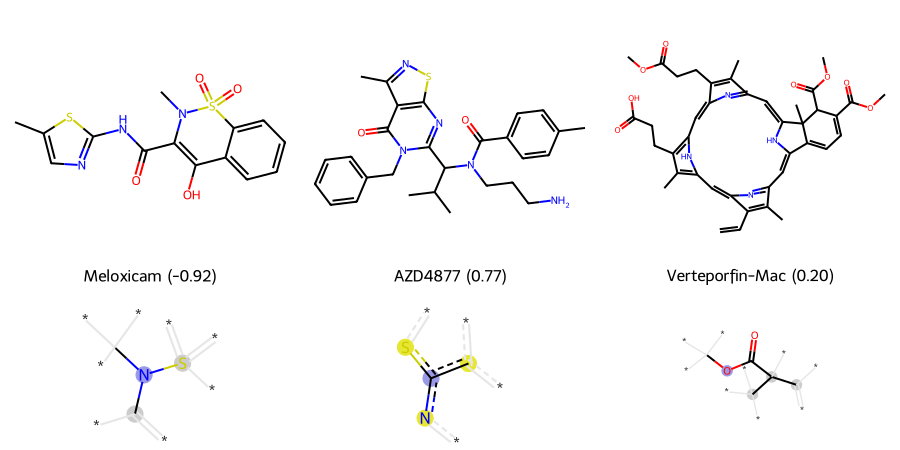

n = 30 (2.42%), mean CL 0.26


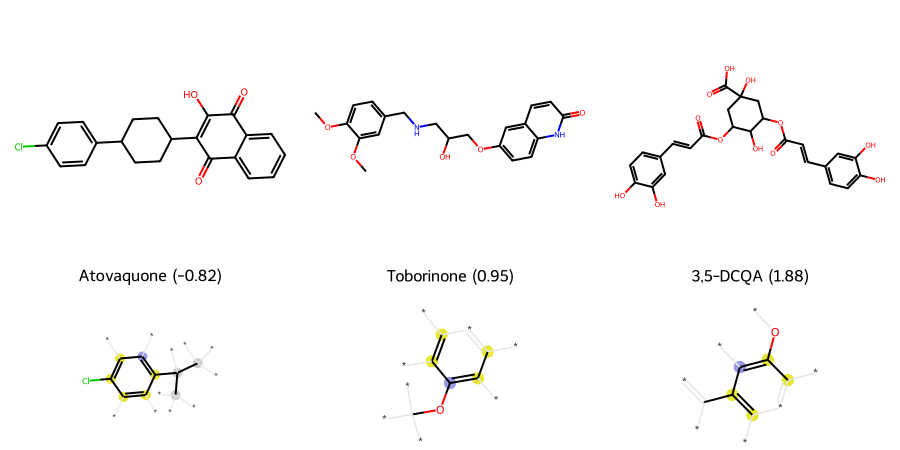

n = 18 (1.45%), mean CL -0.04


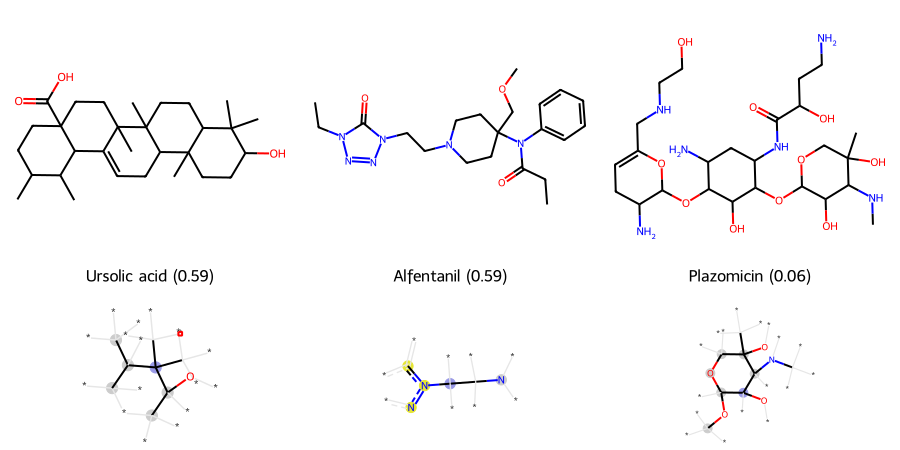

n = 40 (3.23%), mean CL 0.26


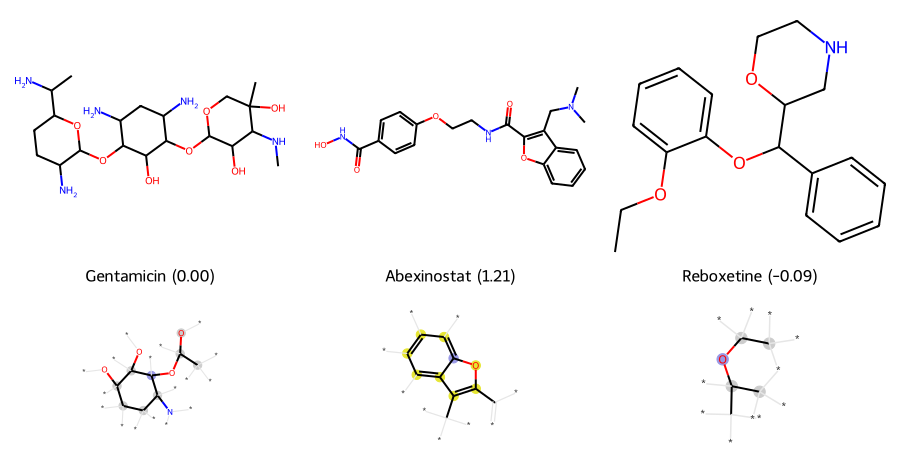

n = 308 (24.86%), mean CL 0.40


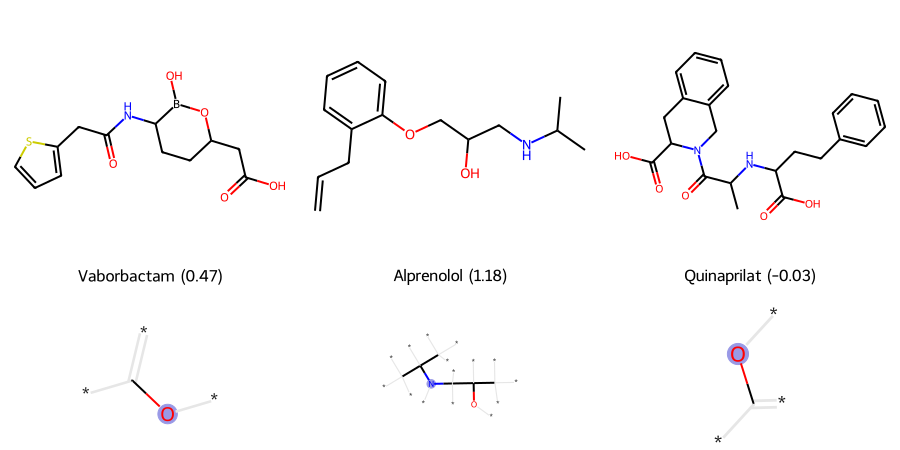

n = 973 (78.53%), mean CL 0.56


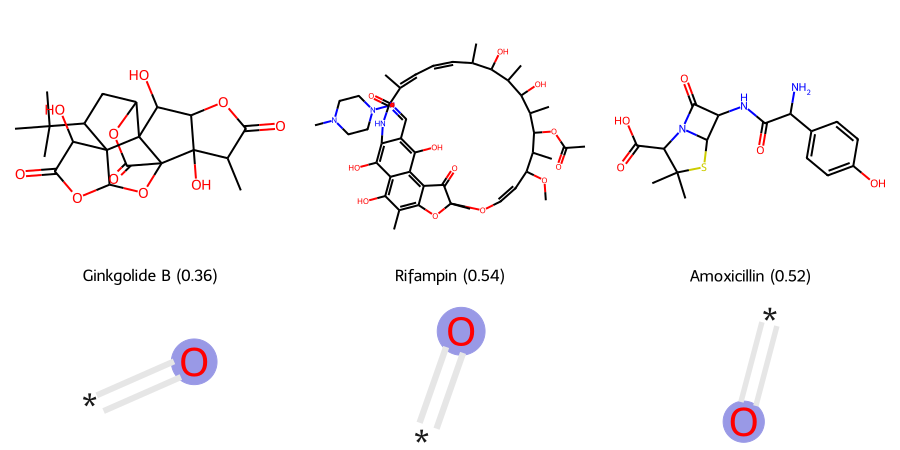

n = 473 (38.18%), mean CL 0.55


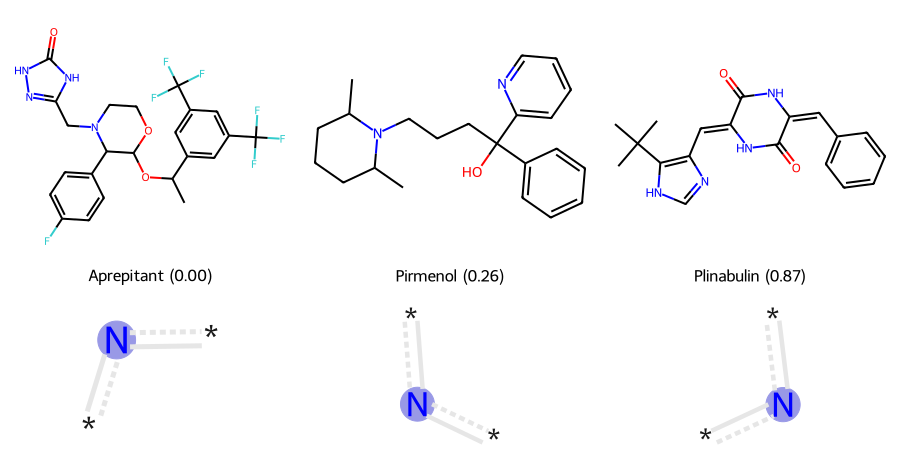

n = 60 (4.84%), mean CL 0.97


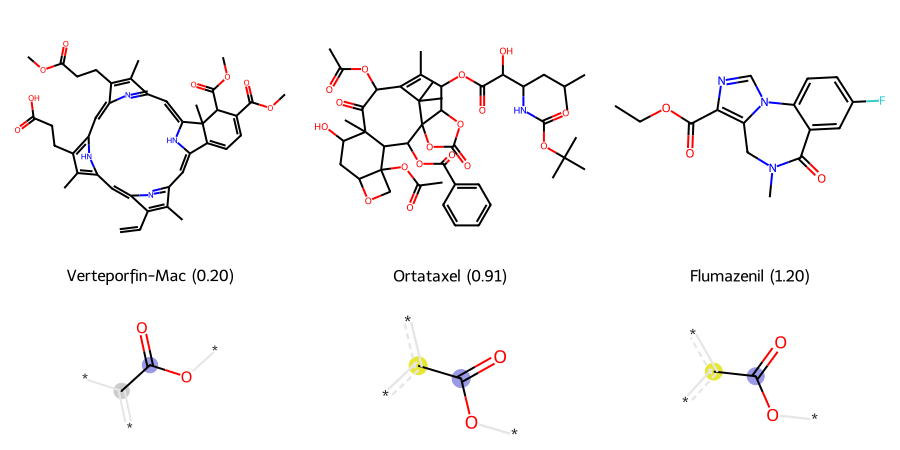

In [ ]:
# Visualize bit features for the 10 most important features for each target (Supplementary Figure S3)
def show_mol(d2d,mol,legend='',highlightAtoms=[]):
    d2d.DrawMolecule(mol,legend=legend, highlightAtoms=highlightAtoms)
    d2d.FinishDrawing()
    bio = BytesIO(d2d.GetDrawingText())
    return Image.open(bio)

def draw_morganfp_bit(bit, dataset, model_name, max_mols=10):
    features = dataset.getFeatures(raw=True, concat=True, ordered=True)
    
    # Get indices where bit is 1
    bit_indices = features[features[f'MorganFP_{bit}'] == 1]
     
    # Get the molecules with the bit
    bit_mols = dataset.getDF().loc[bit_indices.index]
    
    prop = dataset.name.split('_')[0]
    text_for_img = (
        f"n = {len(bit_mols)} ({(len(bit_mols)/len(dataset))*100:.2f}%), "
        f"mean {prop} {bit_mols[prop].mean():.2f}"
    )
    print(text_for_img)
    
    # pick max_mols at random from bit_mols
    bit_mols = bit_mols.sample(max_mols, random_state=42)
    
    bit_values = bit_mols[prop]
    bit_Name = bit_mols.Name if 'Name' in bit_mols.columns else bit_mols.InChIKey
    bit_legend = [f'{cid} ({prop:.2f})' for cid, prop in zip(bit_Name, bit_values)]    

    # create mol images with the pchembl value and CID as legend
    mols = [Chem.MolFromSmiles(smi) for smi in bit_mols.SMILES]
    mol_imgs = [show_mol(Draw.MolDraw2DCairo(300, 300), mol, legend=legend) for mol, legend in zip(mols, bit_legend)]
    bit_mols = [Chem.AddHs(mol) for mol in mols]

    # make images of the bit
    bit_imgs = []
    for i, mol in enumerate(bit_mols):
        bi = {}
        rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=2048, bitInfo=bi)
        bit_imgs.append(Draw.DrawMorganBit(mol, bit, bi))
        
    def concatenate_images(img1, img2, orientation='horizontal'):
        if orientation == 'horizontal':
            total_width = img1.width + img2.width
            max_height = max(img1.height, img2.height)
            new_img = Image.new("RGB", (total_width, max_height), color=(255, 255, 255))
            new_img.paste(img1, (0, (max_height - img1.height) // 2))
            new_img.paste(img2, (img1.width, (max_height - img2.height) // 2))
        else:
            max_width = max(img1.width, img2.width)
            total_height = img1.height + img2.height
            new_img = Image.new("RGB", (max_width, total_height), color=(255, 255, 255))
            new_img.paste(img1, ((max_width - img1.width) // 2, 0))
            new_img.paste(img2, ((max_width - img2.width) // 2, img1.height))

        return new_img
    
    mol_plus_bit_imgs = [concatenate_images(img1, img2, orientation='vertical') for img1, img2 in zip(mol_imgs, bit_imgs)]
    concatenated_img = mol_plus_bit_imgs[0]
    for img in mol_plus_bit_imgs[1:]:
        concatenated_img = concatenate_images(concatenated_img, img, orientation='horizontal')
    display(concatenated_img)
    # save the image
    concatenated_img.save(f'{QSPR_FIGURES_PATH}/feature_importance/{model_name}_morganfp_{bit}.png')
    return text_for_img

# A2AR important bits
print(f"Dataset average A2AR: {best_data_A2AR.df.A2AR.mean():.2f}")
text_for_img_A2AR = []
bits_A2AR = [int(feature.removeprefix("MorganFP_")) for feature in importance_df_A2AR.index[:10].values if feature.startswith('MorganFP')]
for bit in bits_A2AR:
    text_for_img_A2AR.append(draw_morganfp_bit(bit, best_data_A2AR, os.path.basename(best_model_A2AR_path).removesuffix('_meta.json'), max_mols=3))
    
# FU important bits
print(f"Dataset average FU: {best_data_FU.df.FU.mean():.2f}")
FU_avg = best_data_FU.df.FU.mean()
text_for_img_FU = []
bits_FU = [int(feature.removeprefix("MorganFP_")) for feature in importance_df_FU.index[:10].values if feature.startswith('MorganFP')]
for bit in bits_FU:
    text_for_img_FU.append(draw_morganfp_bit(bit, best_data_FU, os.path.basename(best_model_FU_path).removesuffix('_meta.json'), max_mols=3))

# VDSS important bits
print(f"Dataset average VDSS: {best_data_VDSS.df.VDSS.mean():.2f}")
VDSS_avg = best_data_VDSS.df.VDSS.mean()
text_for_img_VDSS = []
bits_VDSS = [int(feature.removeprefix("MorganFP_")) for feature in importance_df_VDSS.index[:10].values if feature.startswith('MorganFP')]
for bit in bits_VDSS:
    text_for_img_VDSS.append(draw_morganfp_bit(bit, best_data_VDSS, os.path.basename(best_model_VDSS_path).removesuffix('_meta.json'), max_mols=3))

# CL important bits
print(f"Dataset average CL: {best_data_CL.df.CL.mean():.2f}")
text_for_img_CL = []
bits_CL = [int(feature.removeprefix("MorganFP_")) for feature in importance_df_CL.index[:10].values if feature.startswith('MorganFP')]
for bit in bits_CL:
    CL_avg = best_data_CL.df.CL.mean()
    text_for_img_CL.append(draw_morganfp_bit(bit, best_data_CL, os.path.basename(best_model_CL_path).removesuffix('_meta.json'), max_mols=3))

In [ ]:
# combine bit images with feature importance images into one image (supplementary figure S3)
image_paths_a2ar = [f'{QSPR_FIGURES_PATH}/feature_importance/{os.path.basename(best_model_A2AR_path).removesuffix("_meta.json")}_morganfp_{bit}.png' for bit in bits_A2AR]
image_paths_fu = [f'{QSPR_FIGURES_PATH}/feature_importance/{os.path.basename(best_model_FU_path).removesuffix("_meta.json")}_morganfp_{bit}.png' for bit in bits_FU]
image_paths_vdss = [f'{QSPR_FIGURES_PATH}/feature_importance/{os.path.basename(best_model_VDSS_path).removesuffix("_meta.json")}_morganfp_{bit}.png' for bit in bits_VDSS]
image_paths_cl = [f'{QSPR_FIGURES_PATH}/feature_importance/{os.path.basename(best_model_CL_path).removesuffix("_meta.json")}_morganfp_{bit}.png' for bit in bits_CL]

def create_combined_image(image_paths, bit_list, text_for_img, model_name, property_name):
    # create a new image with all the bit images
    images = [Image.open(x) for x in image_paths]

    extra_height = 40
    width, height = images[0].size[0], images[0].size[1] + extra_height

    # Create canvas for the final image with total size
    shape = (
        len(bit_list) // 2, 2) if len(bit_list) % 2 == 0 else (len(bit_list) // 2 + 1, 2
    )
    image_size = (width * shape[1], height * shape[0])
    full_image = Image.new('RGB', image_size)
    draw = ImageDraw.Draw(full_image)
    draw.rectangle([0, 0, image_size[0], image_size[1]], fill='white')

    # Paste images into final image
    for row in range(shape[0]):
        for col in range(shape[1]):
            try:
                idx = row * shape[1] + col
                offset = width * col, height * row + extra_height
                full_image.paste(images[idx], offset)
                
                draw = ImageDraw.Draw(full_image)
                text = f"Bit {bit_list[idx]} ({text_for_img[idx]})"
                draw.text(
                    (offset[0]+10, offset[1]-(extra_height-20)),
                    str(text),
                    ImageColor.getcolor(COLOR, "RGB"),
                    font=ImageFont.load_default(size=30)
                )

            except IndexError:
                pass

    full_image.save(f'{QSPR_FIGURES_PATH}/feature_importance/{model_name}_combined_bits.png', dpi=(300, 300))

create_combined_image(image_paths_a2ar, bits_A2AR, text_for_img_A2AR, os.path.basename(best_model_A2AR_path).removesuffix('_meta.json'), 'A2AR')
create_combined_image(image_paths_fu, bits_FU, text_for_img_FU, os.path.basename(best_model_FU_path).removesuffix('_meta.json'), 'FU')
create_combined_image(image_paths_vdss, bits_VDSS, text_for_img_VDSS, os.path.basename(best_model_VDSS_path).removesuffix('_meta.json'), 'VDSS')
create_combined_image(image_paths_cl, bits_CL, text_for_img_CL, os.path.basename(best_model_CL_path).removesuffix('_meta.json'), 'CL')